In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score as sil, calinski_harabasz_score as chs, silhouette_samples

In [3]:
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)

In [20]:
# Supressing Warnings
import warnings
warnings.filterwarnings('ignore')

# 1) Case summary

East-West Airlines is trying to learn more about its customers. Key issues are their flying patterns, earning and use of frequent flyer rewards, and use of the airline credit card. The task is to identify customer segments via clustering. The file EastWestAirlines.xls contains information on 4000 passengers who belong to an airline’s frequent flier program. For each passenger the data include information on their mileage history and on different ways they accrued or spent miles in the last year. The goal is to try to identify clusters of passengers that have similar charactersitics for the purpose of targeting different segments for different types of mileage offers. 

In [5]:
data=pd.read_excel('EastWestAirlines.xlsx',sheet_name='data')

In [6]:
data.head()

,ID#,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award?
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [7]:
data.rename(columns={'ID#':'ID','Award?':'Award'},inplace=True)

In [8]:
data.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
0,1,28143,0,1,1,1,174,1,0,0,7000,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1


In [9]:
data.set_index('ID')

,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,,,,,,,,,,,
1,28143,0,1,1,1,174,1,0,0,7000,0
2,19244,0,1,1,1,215,2,0,0,6968,0
3,41354,0,1,1,1,4123,4,0,0,7034,0
4,14776,0,1,1,1,500,1,0,0,6952,0
5,97752,0,4,1,1,43300,26,2077,4,6935,1
...,...,...,...,...,...,...,...,...,...,...,...
4017,18476,0,1,1,1,8525,4,200,1,1403,1
4018,64385,0,1,1,1,981,5,0,0,1395,1
4019,73597,0,3,1,1,25447,8,0,0,1402,1


# 2. Data Exploration

In [10]:
data.describe()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
count,3999.000000,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.00000,3999.000000,3999.000000,3999.00000,3999.000000
mean,2014.819455,7.360133e+04,144.114529,2.059515,1.014504,1.012253,17144.846212,11.60190,460.055764,1.373593,4118.55939,0.370343
std,1160.764358,1.007757e+05,773.663804,1.376919,0.147650,0.195241,24150.967826,9.60381,1400.209171,3.793172,2065.13454,0.482957
min,1.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,2.00000,0.000000
25%,1010.500000,1.852750e+04,0.000000,1.000000,1.000000,1.000000,1250.000000,3.00000,0.000000,0.000000,2330.00000,0.000000
50%,2016.000000,4.309700e+04,0.000000,1.000000,1.000000,1.000000,7171.000000,12.00000,0.000000,0.000000,4096.00000,0.000000
75%,3020.500000,9.240400e+04,0.000000,3.000000,1.000000,1.000000,23800.500000,17.00000,311.000000,1.000000,5790.50000,1.000000
max,4021.000000,1.704838e+06,11148.000000,5.000000,3.000000,5.000000,263685.000000,86.00000,30817.000000,53.000000,8296.00000,1.000000


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   ID                 3999 non-null   int64
 1   Balance            3999 non-null   int64
 2   Qual_miles         3999 non-null   int64
 3   cc1_miles          3999 non-null   int64
 4   cc2_miles          3999 non-null   int64
 5   cc3_miles          3999 non-null   int64
 6   Bonus_miles        3999 non-null   int64
 7   Bonus_trans        3999 non-null   int64
 8   Flight_miles_12mo  3999 non-null   int64
 9   Flight_trans_12    3999 non-null   int64
 10  Days_since_enroll  3999 non-null   int64
 11  Award              3999 non-null   int64
dtypes: int64(12)
memory usage: 375.0 KB


# checking for null values using PRofileReporting

In [12]:
#ProfileReport(data)

In [13]:
data.isnull().sum().value_counts()

0    12
dtype: int64

# 3. Exploratory Data Analysis

ID


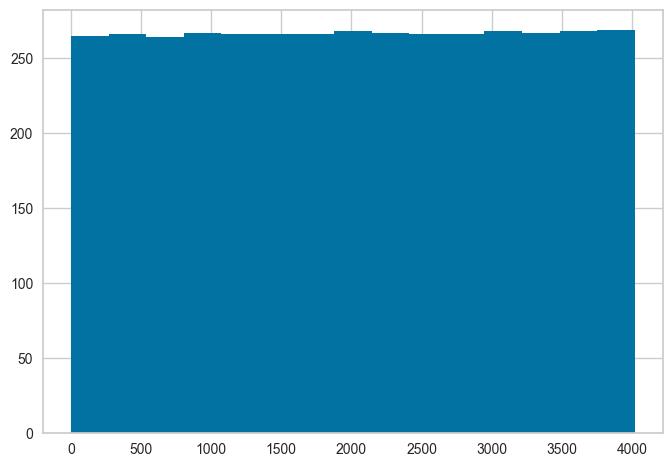

Balance


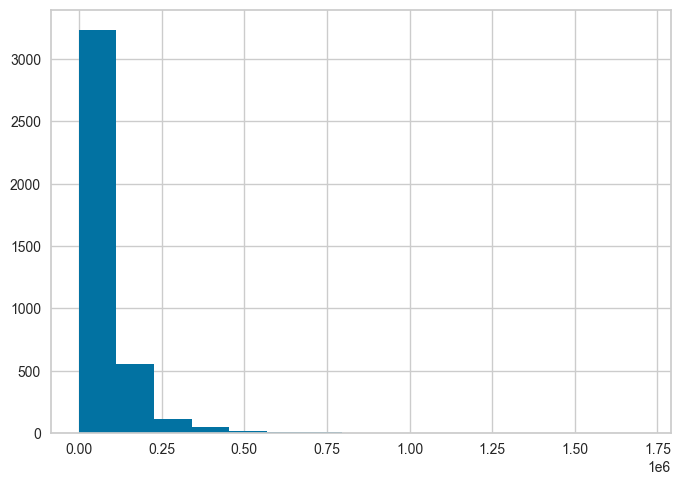

Qual_miles


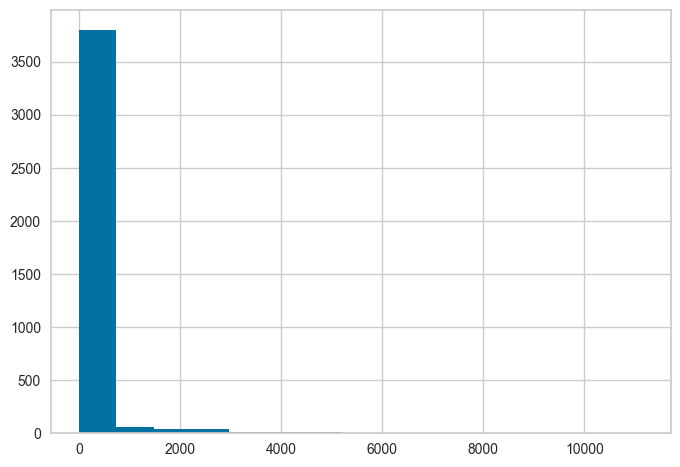

cc1_miles


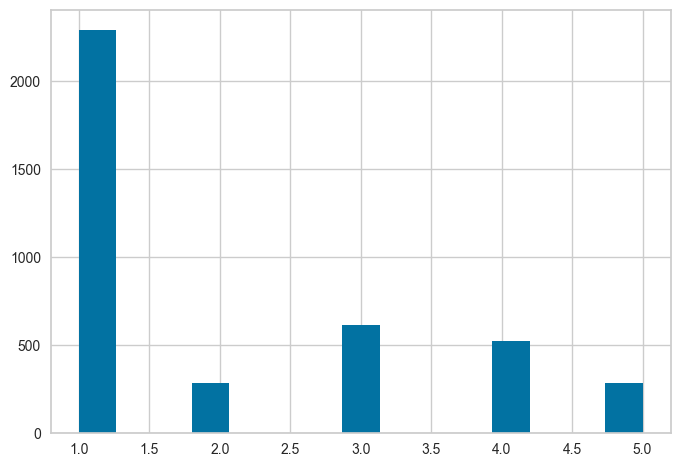

cc2_miles


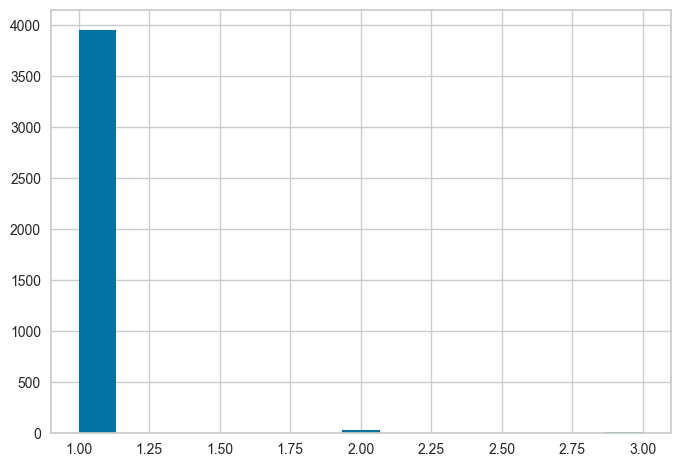

cc3_miles


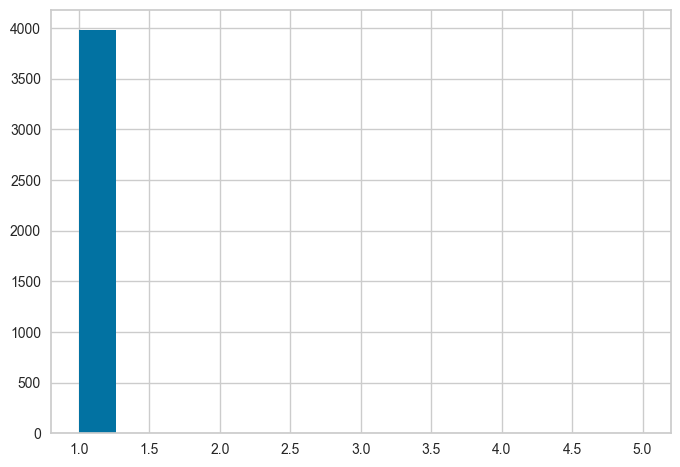

Bonus_miles


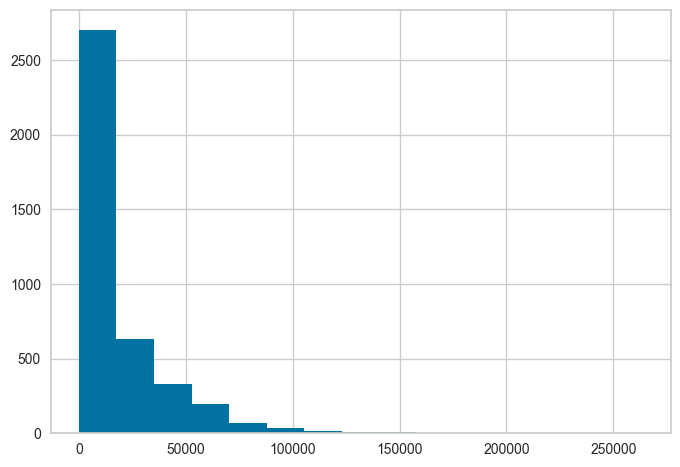

Bonus_trans


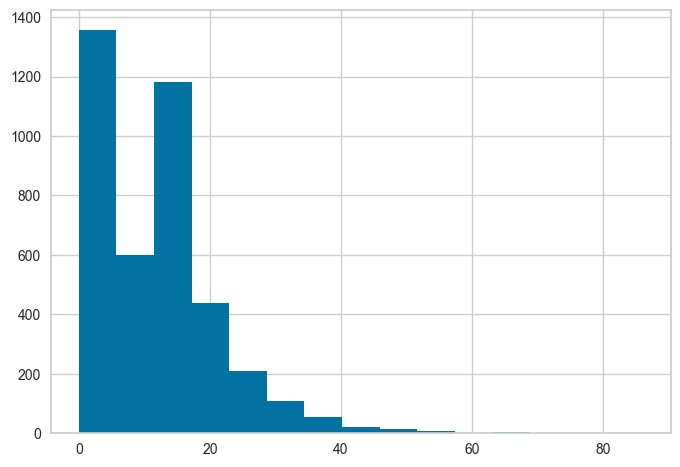

Flight_miles_12mo


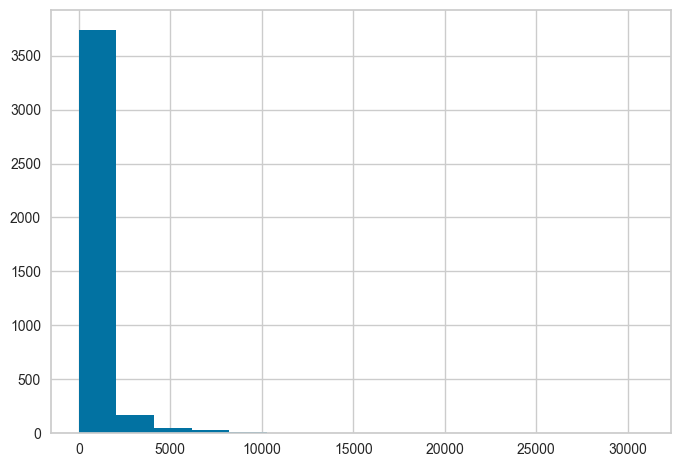

Flight_trans_12


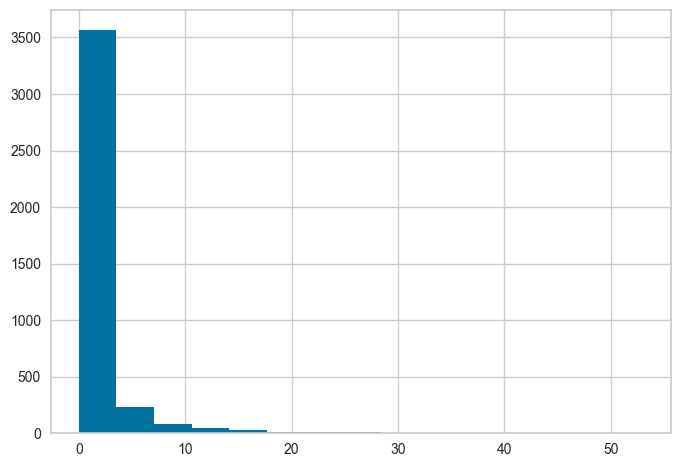

Days_since_enroll


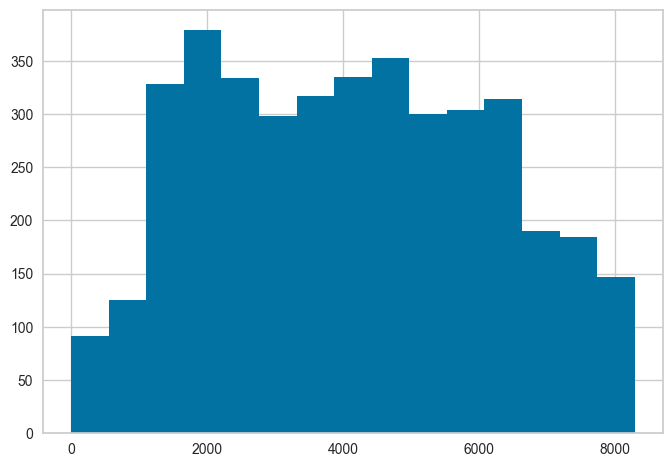

Award


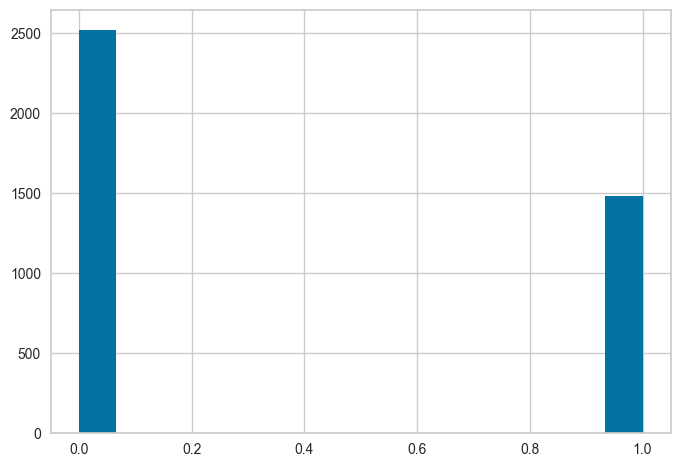

In [14]:
for feature in data.columns:
    print( feature)
    data=data.copy()
    data[feature].hist(bins=15)
    plt.ylabel=('Count')
    plt.title=(feature)
    plt.show()
    

ID


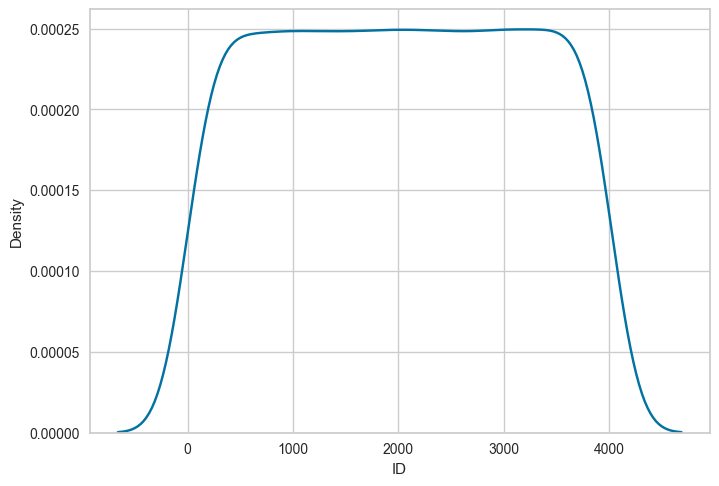

Balance


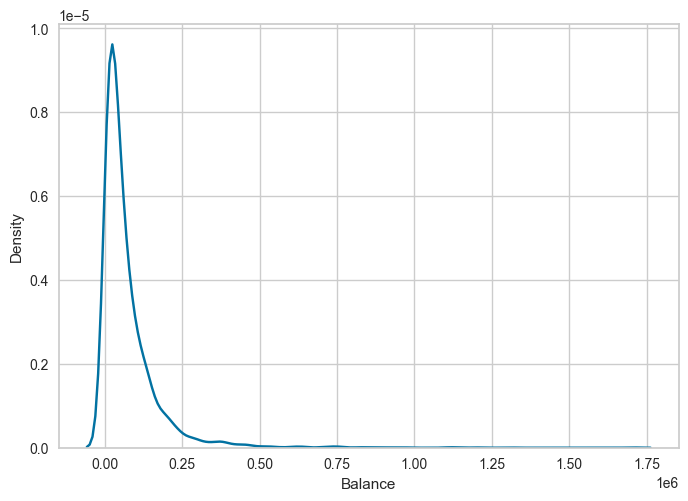

Qual_miles


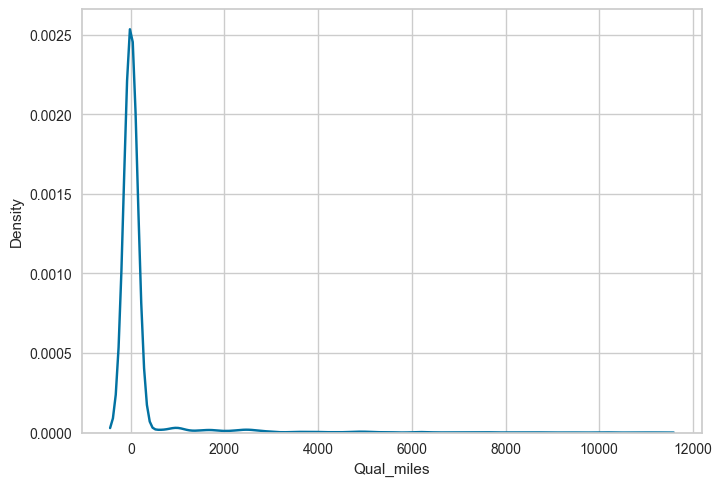

cc1_miles


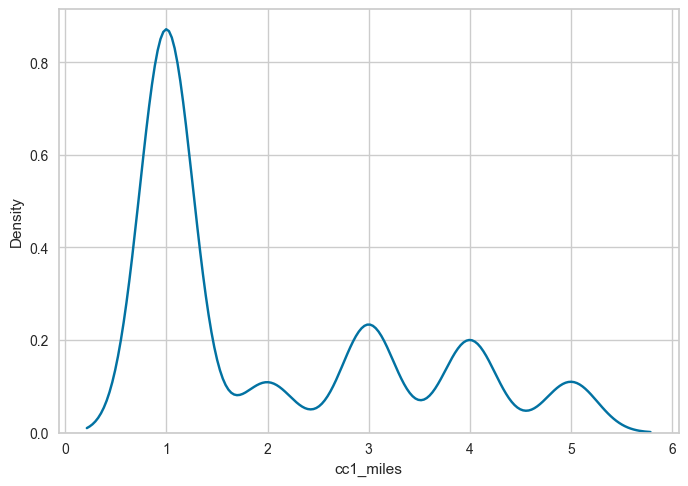

cc2_miles


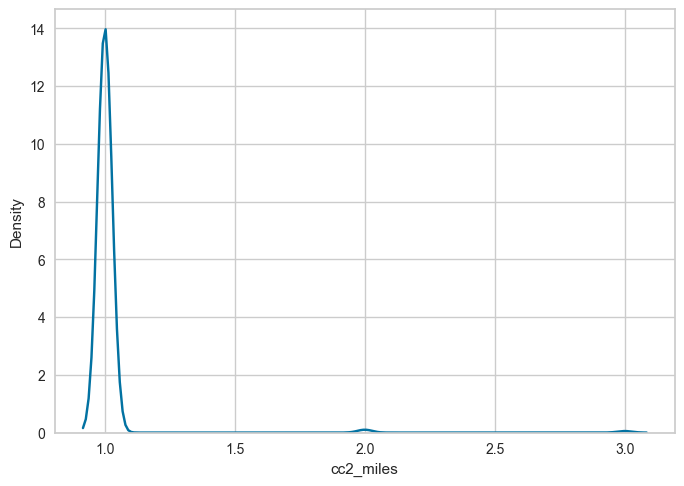

cc3_miles


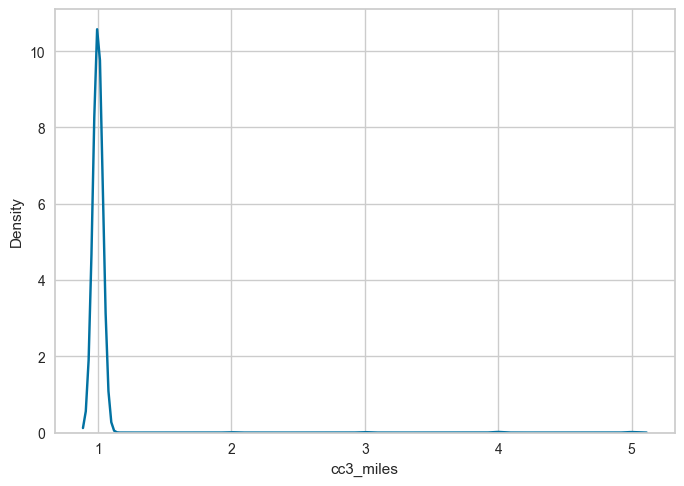

Bonus_miles


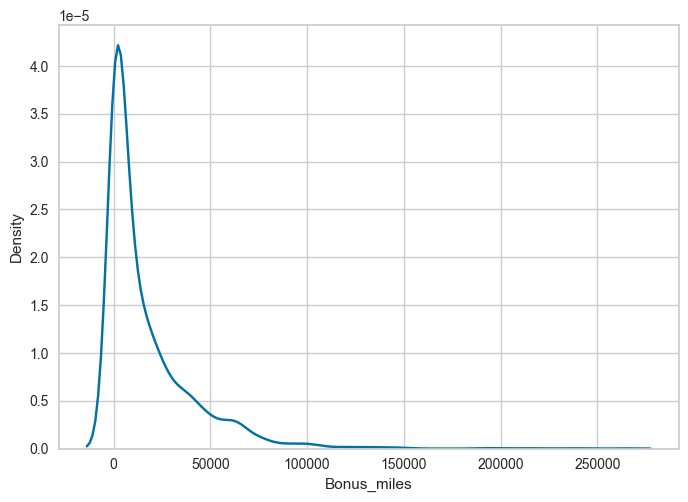

Bonus_trans


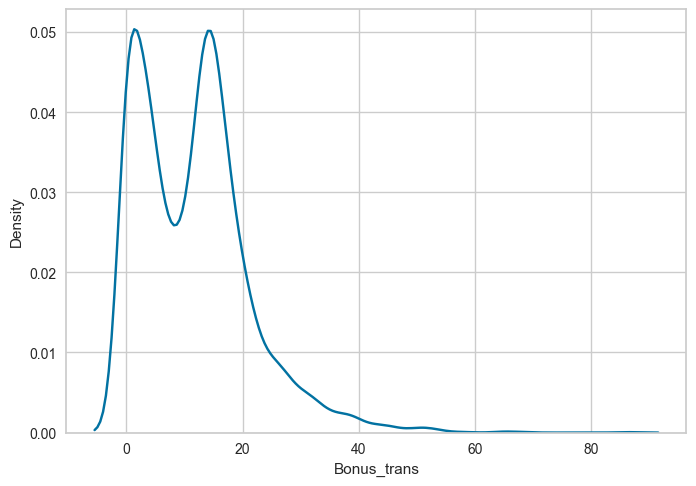

Flight_miles_12mo


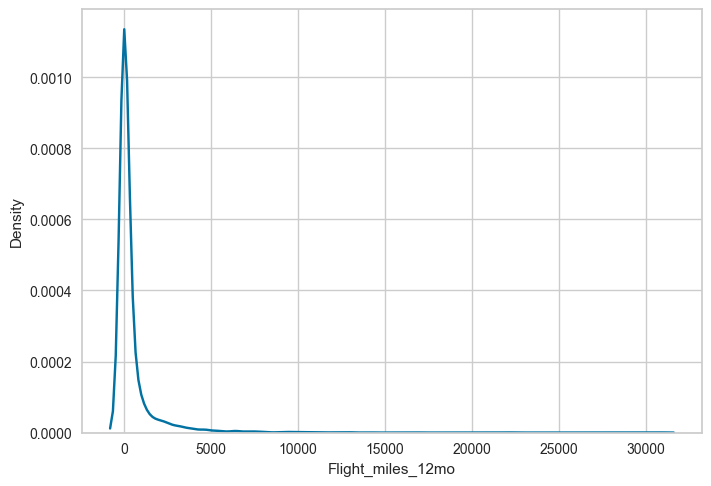

Flight_trans_12


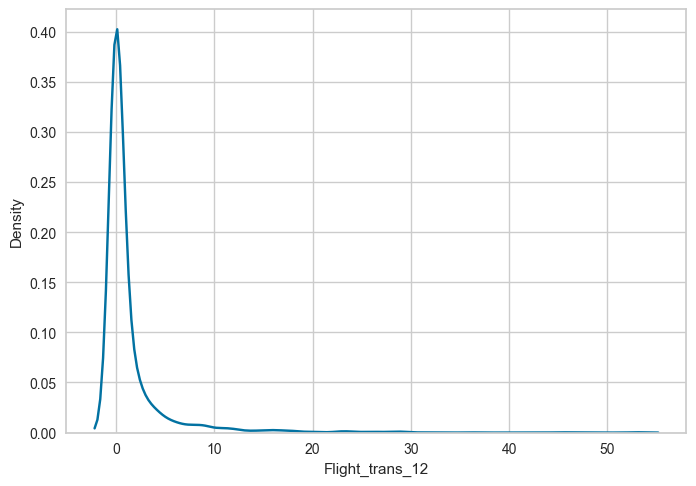

Days_since_enroll


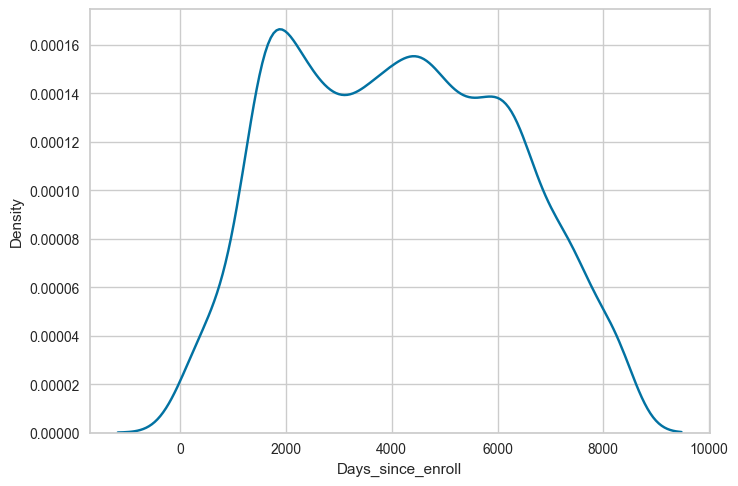

Award


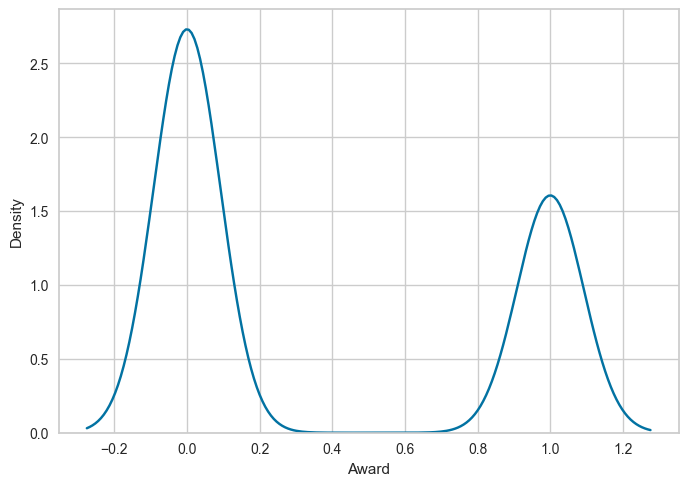

In [15]:
#kernal density for every feature

for n in data.columns:
    print(n)
    sns.kdeplot(data[n])
    plt.show()

In [16]:
data.columns

Index(['ID', 'Balance', 'Qual_miles', 'cc1_miles', 'cc2_miles', 'cc3_miles',
       'Bonus_miles', 'Bonus_trans', 'Flight_miles_12mo', 'Flight_trans_12',
       'Days_since_enroll', 'Award'],
      dtype='object')

# check outliers

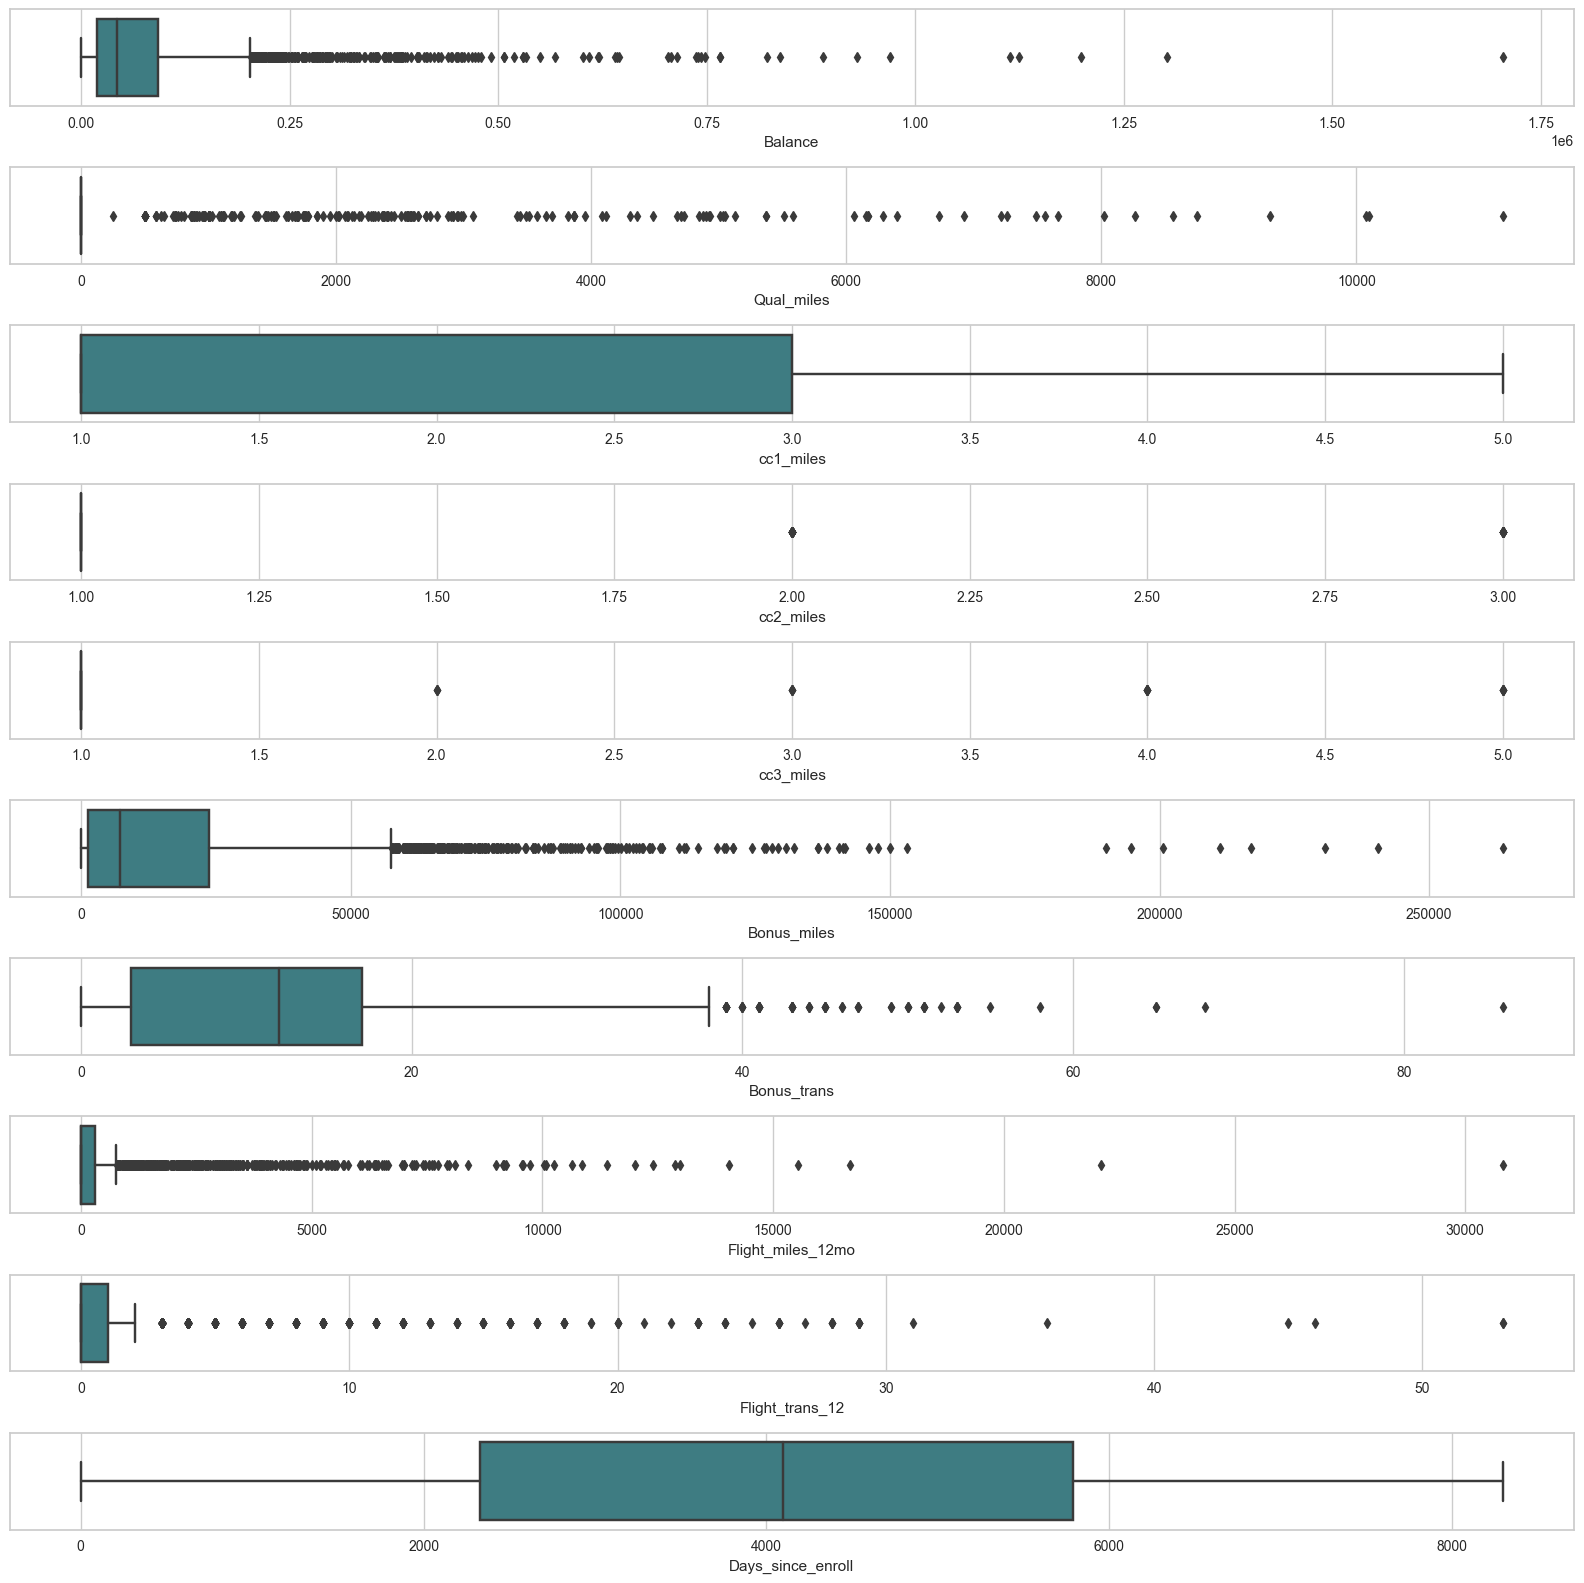

In [17]:
ot=data.copy()
fig,axes=plt.subplots(10,1,figsize=(16,16),sharex=False,sharey=False)
sns.boxplot(x='Balance',data=ot,palette='crest',ax=axes[0])
sns.boxplot(x='Qual_miles',data=ot,palette='crest',ax=axes[1])
sns.boxplot(x='cc1_miles',data=ot,palette='crest',ax=axes[2])
sns.boxplot(x='cc2_miles',data=ot,palette='crest',ax=axes[3])
sns.boxplot(x='cc3_miles',data=ot,palette='crest',ax=axes[4])
sns.boxplot(x='Bonus_miles',data=ot,palette='crest',ax=axes[5])
sns.boxplot(x='Bonus_trans',data=ot,palette='crest',ax=axes[6])
sns.boxplot(x='Flight_miles_12mo',data=ot,palette='crest',ax=axes[7])
sns.boxplot(x='Flight_trans_12',data=ot,palette='crest',ax=axes[8])
sns.boxplot(x='Days_since_enroll',data=ot,palette='crest',ax=axes[9])
plt.tight_layout()


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'ID'),
  Text(1, 0, 'Balance'),
  Text(2, 0, 'Qual_miles'),
  Text(3, 0, 'cc1_miles'),
  Text(4, 0, 'cc2_miles'),
  Text(5, 0, 'cc3_miles'),
  Text(6, 0, 'Bonus_miles'),
  Text(7, 0, 'Bonus_trans'),
  Text(8, 0, 'Flight_miles_12mo'),
  Text(9, 0, 'Flight_trans_12'),
  Text(10, 0, 'Days_since_enroll'),
  Text(11, 0, 'Award')])

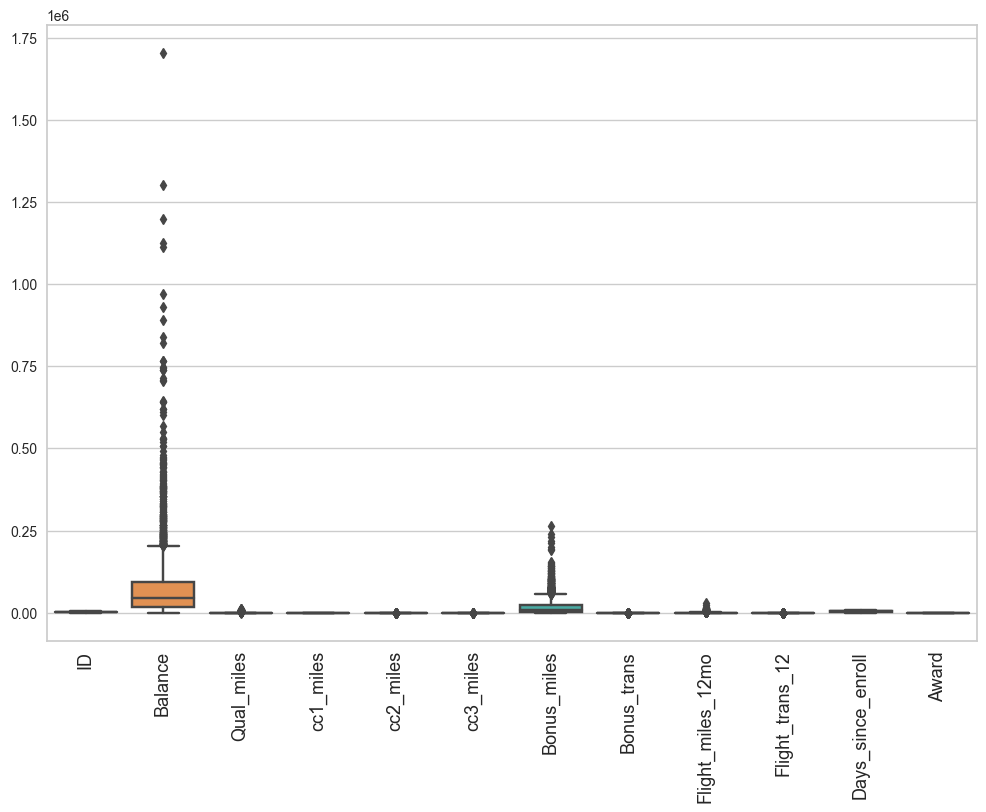

In [18]:
# Box plot for every feature in the same graph
fig=plt.figure(figsize=(12,8))
sns.boxplot(data=data)
plt.xticks(rotation=90,fontsize=13)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'ID'),
  Text(1, 0, 'Balance'),
  Text(2, 0, 'Qual_miles'),
  Text(3, 0, 'cc1_miles'),
  Text(4, 0, 'cc2_miles'),
  Text(5, 0, 'cc3_miles'),
  Text(6, 0, 'Bonus_miles'),
  Text(7, 0, 'Bonus_trans'),
  Text(8, 0, 'Flight_miles_12mo'),
  Text(9, 0, 'Flight_trans_12'),
  Text(10, 0, 'Days_since_enroll'),
  Text(11, 0, 'Award')])

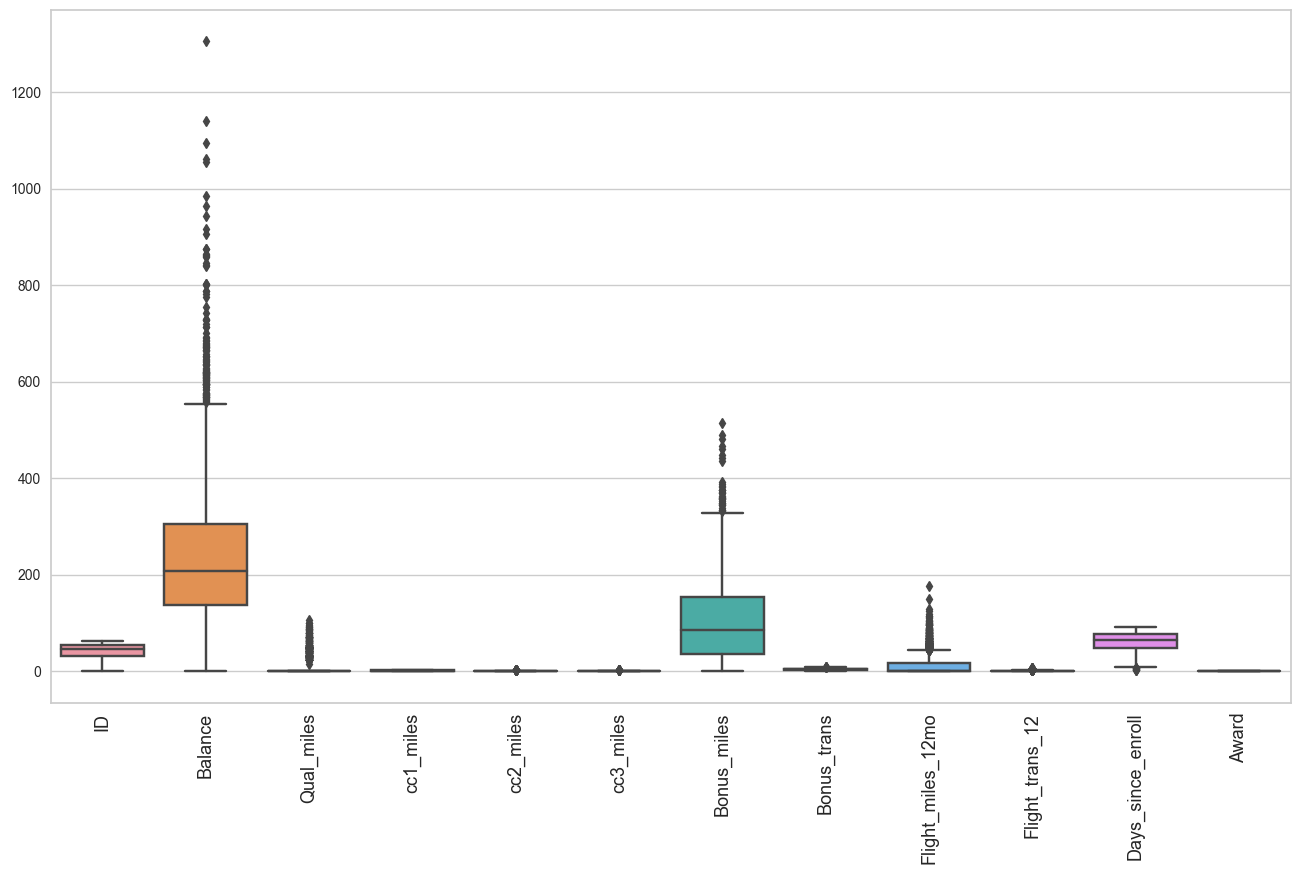

In [19]:
## we use sqrt() to see more clearly despite the outliers
plt.figure(figsize=(16,9))
sns.boxplot(data=np.sqrt(data))
plt.xticks(rotation=90,fontsize=13)

# 4. Data visualization

In [161]:
countNotermdeposite=len(data[data.Award==0])
counthavetermdeposite=len(data[data.Award==1])
print('percentage of customer doesnt have a Award : {:.2f}%'.format((countNotermdeposite/(len(data.Award))*100)))
print('percentage of customer have a Award : {:.2f}%'.format((counthavetermdeposite/(len(data.Award))*100)))

percentage of customer doesnt have a Award : 62.97%
percentage of customer have a Award : 37.03%


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

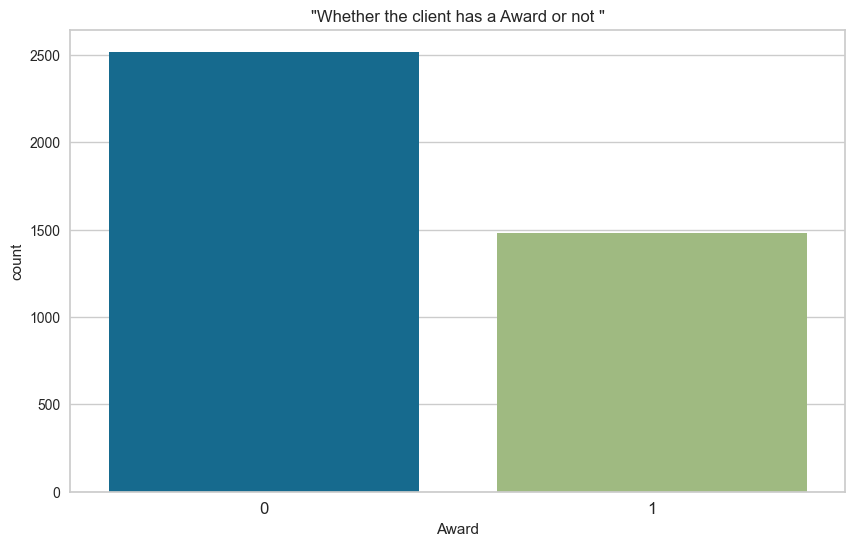

In [162]:
plt.figure(figsize=(10,6))
ax=sns.countplot(x='Award', data=data, order=data['Award'].value_counts().index)
ax.set(title='"Whether the client has a Award or not "')
plt.xticks(fontsize = 12)


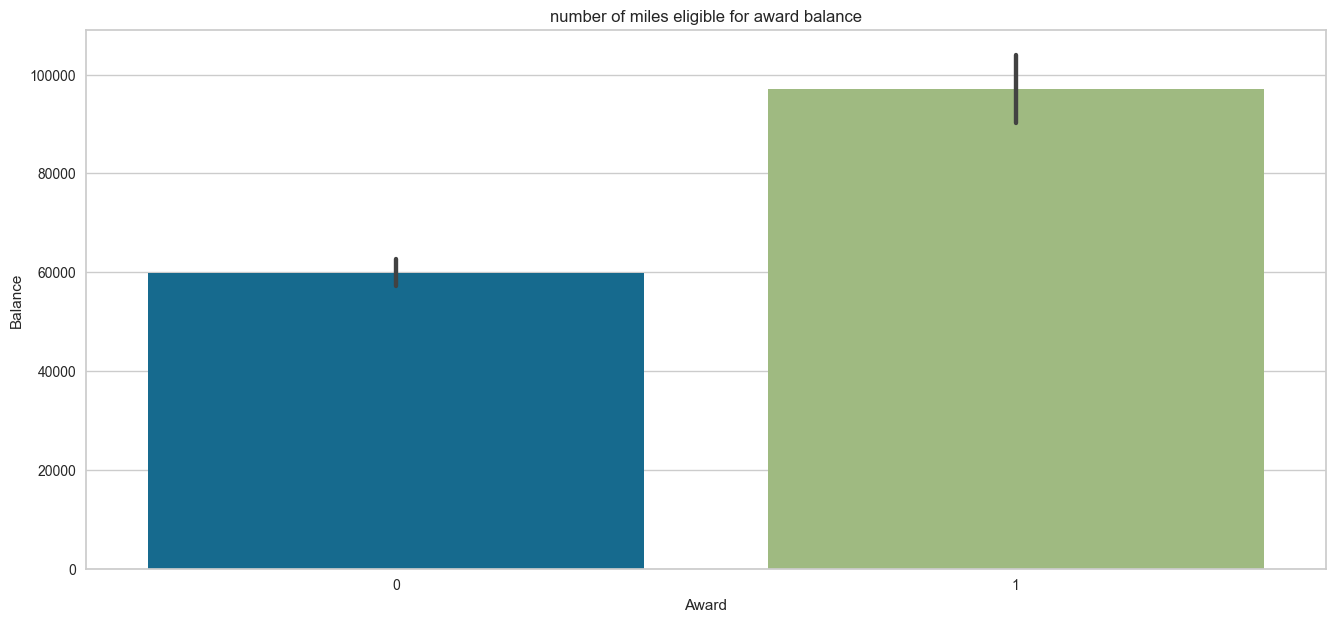

In [163]:
#balance: number of miles eligible for award balance

plt.figure(figsize=(16,7))
Balance=data[['Award','Balance']].sort_values('Balance', ascending=True)
ax=sns.barplot(x='Award',y='Balance',data=Balance)
ax.set(xlabel='Award',ylabel='Balance',title='number of miles eligible for award balance')
plt.show()

In [164]:
data.corr()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
ID,1.000000,-0.243737,-0.019374,-0.224465,0.020291,-0.014707,-0.203012,-0.146915,-0.031013,-0.052096,-0.964988,-0.177901
Balance,-0.243737,1.000000,0.108722,0.338344,-0.008804,0.035243,0.403487,0.324935,0.217551,0.255700,0.263129,0.178494
Qual_miles,-0.019374,0.108722,1.000000,0.007931,-0.013923,-0.007779,0.031021,0.050725,0.126774,0.144004,0.017312,0.095256
cc1_miles,-0.224465,0.338344,0.007931,1.000000,-0.068223,0.060555,0.825200,0.608943,0.037370,0.041333,0.230849,0.335457
cc2_miles,0.020291,-0.008804,-0.013923,-0.068223,1.000000,-0.006166,-0.003969,0.064399,0.010598,0.028284,-0.005807,0.005332
cc3_miles,-0.014707,0.035243,-0.007779,0.060555,-0.006166,1.000000,0.204134,0.097313,-0.001777,-0.001117,0.010832,0.023484
Bonus_miles,-0.203012,0.403487,0.031021,0.825200,-0.003969,0.204134,1.000000,0.603180,0.183536,0.185261,0.210397,0.373506
Bonus_trans,-0.146915,0.324935,0.050725,0.608943,0.064399,0.097313,0.603180,1.000000,0.377216,0.432364,0.161262,0.333893
Flight_miles_12mo,-0.031013,0.217551,0.126774,0.037370,0.010598,-0.001777,0.183536,0.377216,1.000000,0.869193,0.037271,0.217715
Flight_trans_12,-0.052096,0.255700,0.144004,0.041333,0.028284,-0.001117,0.185261,0.432364,0.869193,1.000000,0.059260,0.247909


In [165]:
#sns.pairplot(data)

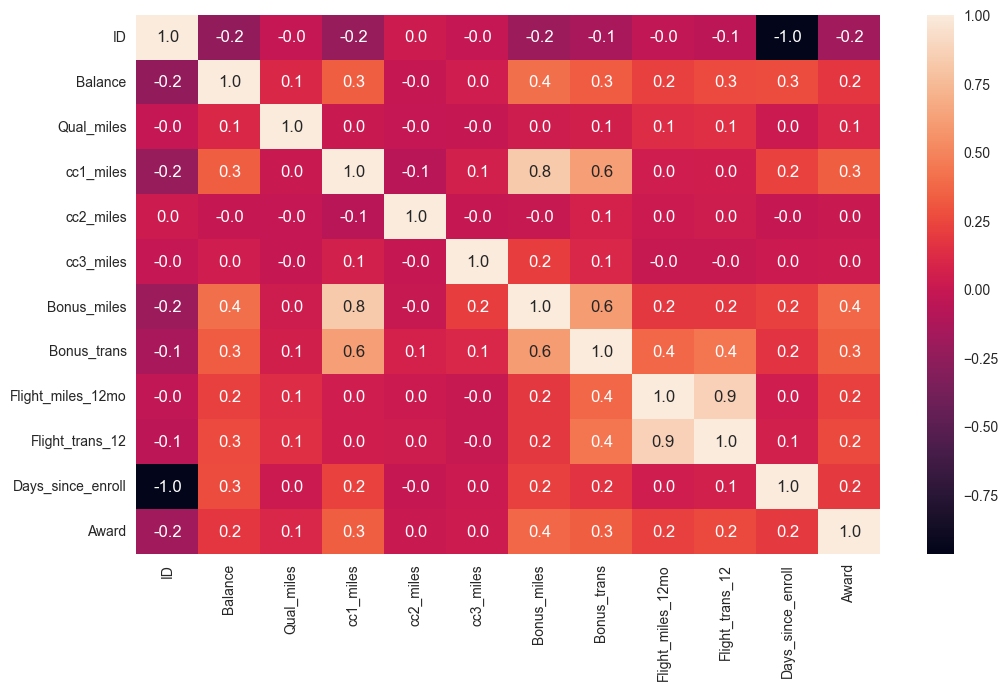

In [166]:
f,ax=plt.subplots(figsize=(12,7))
sns.heatmap(data.corr(),annot=True,fmt='.1f',ax=ax)
plt.show()

# 5. Data Processing

In [167]:
standard_scaler=StandardScaler()
std_df=standard_scaler.fit_transform(data)
std_df=pd.DataFrame(std_df,columns=data.columns)

In [168]:
std_df.shape

(3999, 12)

# 6. Normalizing the data

In [169]:
scaler=MinMaxScaler()
data_norm=scaler.fit_transform(data)
data_norm=pd.DataFrame(data_norm,columns=data.columns)
data_norm.shape

(3999, 12)

# K-Means Clustering

#fter all the analyses we now start with the K-Means Clustering procedure
K-means is a centroid-based algorithm, or a distance-based algorithm, where we calculate the distances to assign a point to a cluster. In K-Means, each cluster is associated with a centroid.

The main objective of the K-Means algorithm is to minimize the sum of distances between the points and their respective cluster centroid. The first step in k-means is to pick the number of clusters, k. Then keep the iterations running until one of the below satisifes:

Centroids of newly formed clusters do not change

Points remain in the same cluster


Maximum number of iterations are reached

In K Means clustering we need to first assign the K number of clusters which can be taken up using the thumb rule of "Sqrt(n)/2" or plotting the Elbow curve, aka Scree plot.

# Elbow Method for Determining Cluster Amount




In [170]:
cluster_range=range(1,15)
cluster_error=[]
for k in cluster_range:
    cluster=KMeans(k,n_init=10)
    cluster.fit(std_df)
    centroids=cluster.cluster_centers_
    cluster_error.append(cluster.inertia_)
cluster_df=pd.DataFrame({'number_cluster':cluster_range,'Cluster_error':cluster_error})
cluster_df

,number_cluster,Cluster_error
0,1,47988.000000
1,2,39018.789849
2,3,34529.134292
3,4,30616.548928
4,5,26894.771760
5,6,23493.579211
6,7,21883.873229
7,8,19330.130106
8,9,18014.274047
9,10,16769.982135


In [171]:
# within-cluster sum-of-squares criterion 
# Use Elbow Graph to find optimum number of  clusters (K value) from K values range
# The K-means algorithm aims to choose centroids that minimise the inertia, or within-cluster sum-of-squares criterion WCSS 
# random state can be anything from 0 to 42, but the same number to be used everytime, so that the results don't change. 


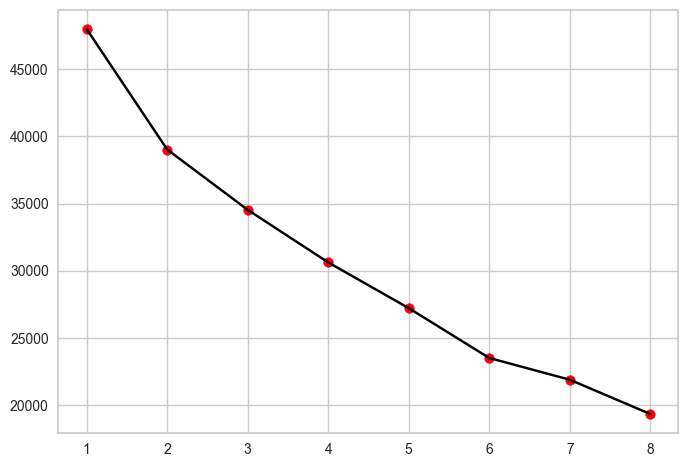

In [172]:
wcss=[]
for i in range(1,9):
    kmean=KMeans(n_clusters=i,random_state=2)
    kmean.fit(std_df)
    wcss.append(kmean.inertia_)
    
#plot k value
plt.plot(range(1,9),wcss,color = 'black')
plt.scatter(range(1,9),wcss,color='red')

plt.title=('Elbow Graph for Standard Scaler')
plt.xlabel=('Number of clusters')
plt.ylabel=('WCSS')
plt.show()

# lets check for the silhouette score

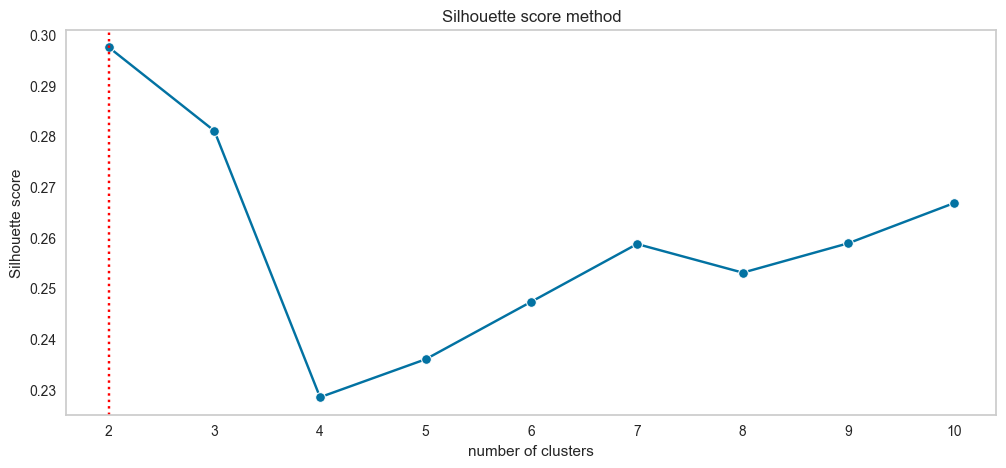

In [173]:
from sklearn.metrics import silhouette_score
n_cluster=[2,3,4,5,6,7,8,9,10]
cluster_inertia=[]
s_scores=[]
for i in n_cluster:
    kmean=KMeans(n_clusters=i,init='k-means++').fit(std_df)
    cluster_inertia.append(kmean.inertia_) 
    silhouette_avg=silhouette_score(std_df,kmean.labels_)
    s_scores.append(silhouette_avg)
    
fig,ax=plt.subplots(figsize=(12,5))
ax=sns.lineplot(n_cluster,s_scores,ax=ax,marker='o')
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(2, ls=":", c="red")
plt.grid()
plt.show()
    

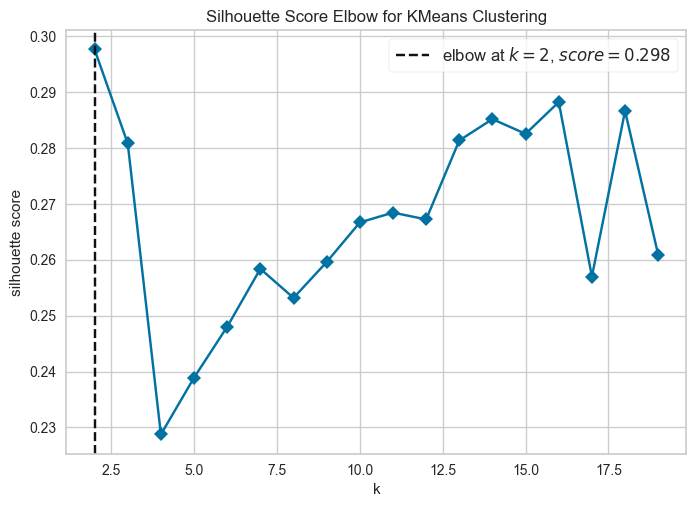

In [174]:
from yellowbrick.cluster import KElbowVisualizer

model=KMeans(random_state=10,max_iter=500,init='k-means++')
visualizer=KElbowVisualizer(model,k=(2,20),metric='silhouette',timings=False)
visualizer.fit(std_df)
visualizer.poof()
plt.show()

In [175]:
clust_list = [2,3,4,5,6,7,8,9]

#  Silhouette score for stadardScaler applied on data.

for n_clusters in clust_list:
    clusterer1 = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels1 = clusterer1.fit_predict(std_df)
    sil_score1= sil(std_df, cluster_labels1)
    print("For n_clusters =", n_clusters,"The average silhouette_score is :", sil_score1)

For n_clusters = 2 The average silhouette_score is : 0.2979332294964896
For n_clusters = 3 The average silhouette_score is : 0.28132087151477925
For n_clusters = 4 The average silhouette_score is : 0.2287218085633998
For n_clusters = 5 The average silhouette_score is : 0.23890516538353704
For n_clusters = 6 The average silhouette_score is : 0.24755064720991263
For n_clusters = 7 The average silhouette_score is : 0.24211334683095515
For n_clusters = 8 The average silhouette_score is : 0.2530376128959621
For n_clusters = 9 The average silhouette_score is : 0.2596383258629409


# Build KMeans Cluster algorithm using K=2 and MinMaxScaler Applied Dataset

In [176]:
model_kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++')
y_predict_kmeans = model_kmeans.fit_predict(data_norm)
y_predict_kmeans.shape

(3999,)

In [177]:
y_predict_kmeans

array([1, 1, 1, ..., 0, 1, 1])

In [178]:
model_kmeans.labels_

array([1, 1, 1, ..., 0, 1, 1])

In [179]:
model_kmeans.cluster_centers_


array([[4.33978319e-01, 5.69280197e-02, 2.15461508e-02, 4.15428764e-01,
        7.76502363e-03, 4.55773126e-03, 1.09621005e-01, 1.83518364e-01,
        2.78255837e-02, 4.90489598e-02, 5.57398375e-01, 1.00000000e+00],
       [5.40340593e-01, 3.50812450e-02, 7.85813260e-03, 1.76330421e-01,
        6.94996029e-03, 2.18427323e-03, 3.87875269e-02, 1.06313612e-01,
        7.34309944e-03, 1.23113582e-02, 4.60411394e-01, 5.49560397e-15]])

In [180]:
model_kmeans.inertia_

1146.459517093534

In [181]:
#Assign clusters to the data set
df = pd.read_excel('EastWestAirlines.xlsx', sheet_name='data')
df.rename({'ID#':'ID', 'Award?':'Award'}, inplace=True, axis=1)
df['Kmeans_label'] = model_kmeans.labels_

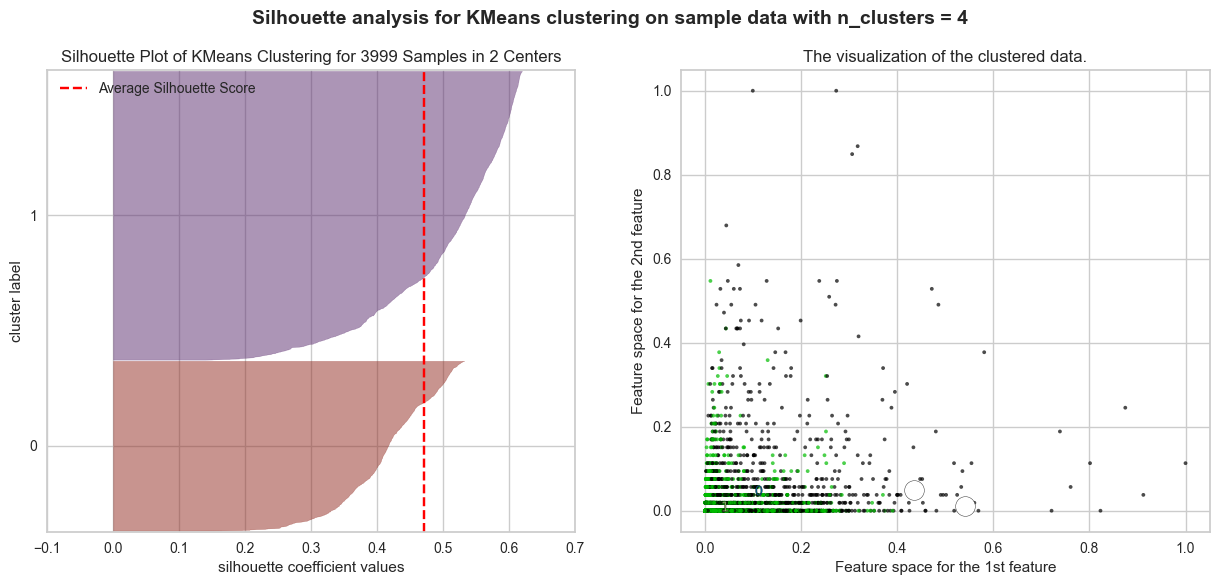

In [182]:
from yellowbrick.cluster import SilhouetteVisualizer

fig,(ax1,ax2) = plt.subplots(1,2,sharey=False)
fig.set_size_inches(15,6)



sil_visualizer1 = SilhouetteVisualizer(model_kmeans,ax= ax1, colors=['#922B21','#5B2C6F','#1B4F72','#32a84a'])
sil_visualizer1.fit(data_norm)


# 2nd Plot showing the actual clusters formed

import matplotlib.cm as cm
colors1 = cm.nipy_spectral(model_kmeans.labels_.astype(float) / 2) # 2 is number of clusters
ax2.scatter(data_norm.iloc[:, 6], data_norm.iloc[:, 9], marker='.', s=30, lw=0, alpha=0.7,
                c=colors1, edgecolor='k')

# Labeling the clusters
centers1 = model_kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers1[:, 0], centers1[:, 9], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers1):
    ax2.scatter(c[6], c[9], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')


ax2.set_title(label ="The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % 4),fontsize=14, fontweight='bold')

sil_visualizer1.show()
plt.show()

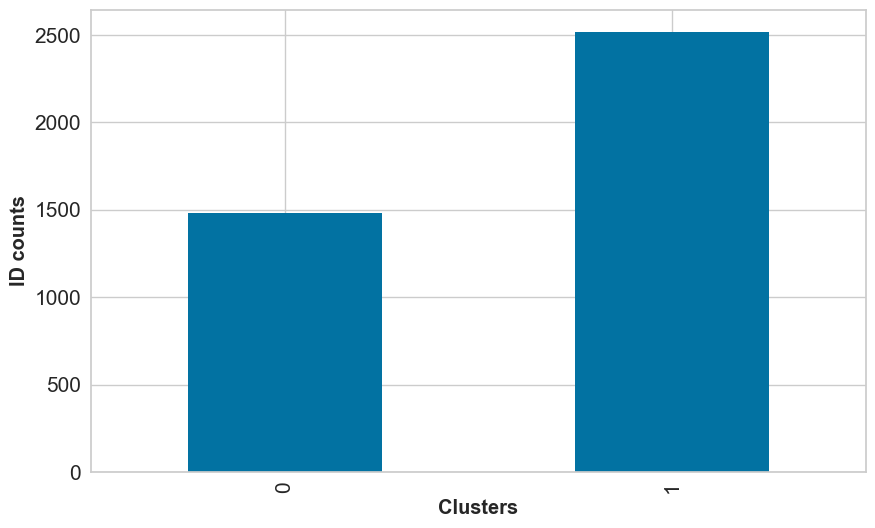

In [183]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Kmeans_label']).count()['ID'].plot(kind='bar')
plt.ylabel=('ID Counts')
plt.title=('Kmeans Clustering Standard Scaler Applied')
ax.set_xlabel('Clusters', fontsize='large', fontweight='bold')
ax.set_ylabel('ID counts', fontsize='large', fontweight='bold')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [184]:
# Group data by Clusters (K=2)
df.groupby('Kmeans_label').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Kmeans_label,,,,,,,,,,,,
0,1745.592843,97053.051317,240.196489,2.661715,1.01553,1.018231,28905.414585,15.782579,857.501013,2.599595,4625.062120,1.0
1,2173.169182,59807.839555,87.602462,1.705322,1.01390,1.008737,10227.689039,9.142971,226.292295,0.652502,3820.652105,0.0


# We can now clearly see the 2 number of clusters formed, which can be described as under

In [185]:
#Cluster1, Tier 1 = "1" = Defines the group of fliers that earn the most out of the card and are frequent fliers
#Cluster0, Tier 2 = "0" = Defines the group of fliers that earn the least and are the least frequent fliers

# HEIRARICAL Clustering


# Dendogram on MinMaxScaler Applied on Datase

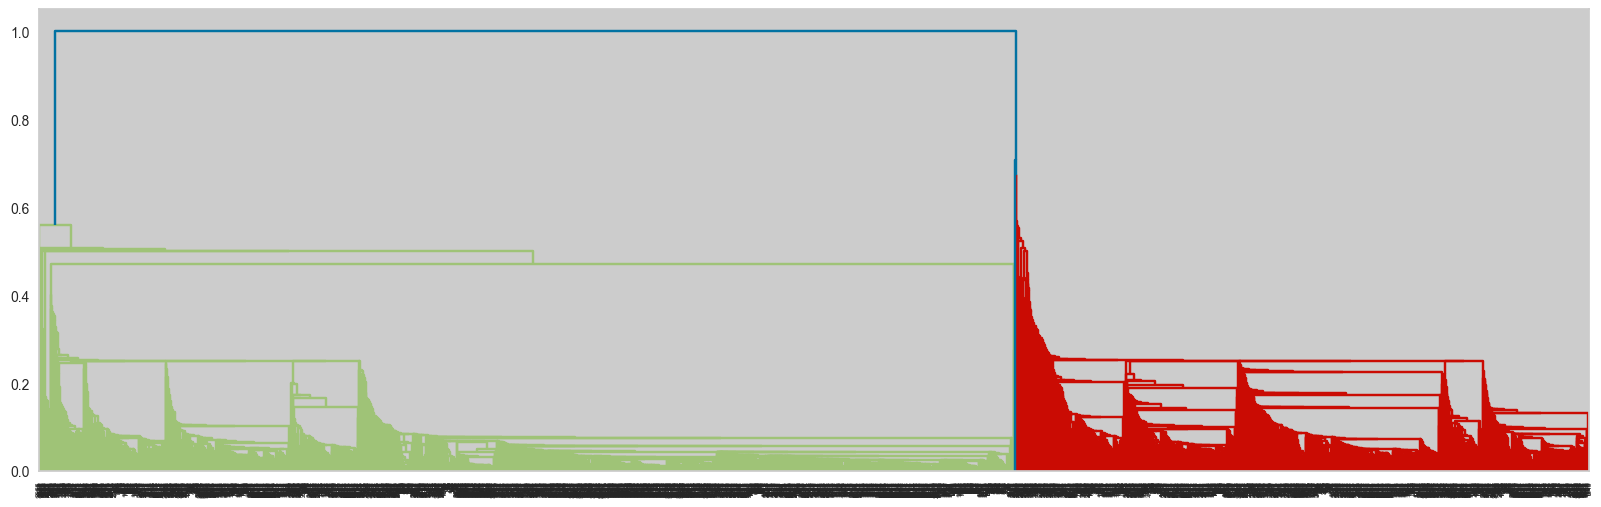

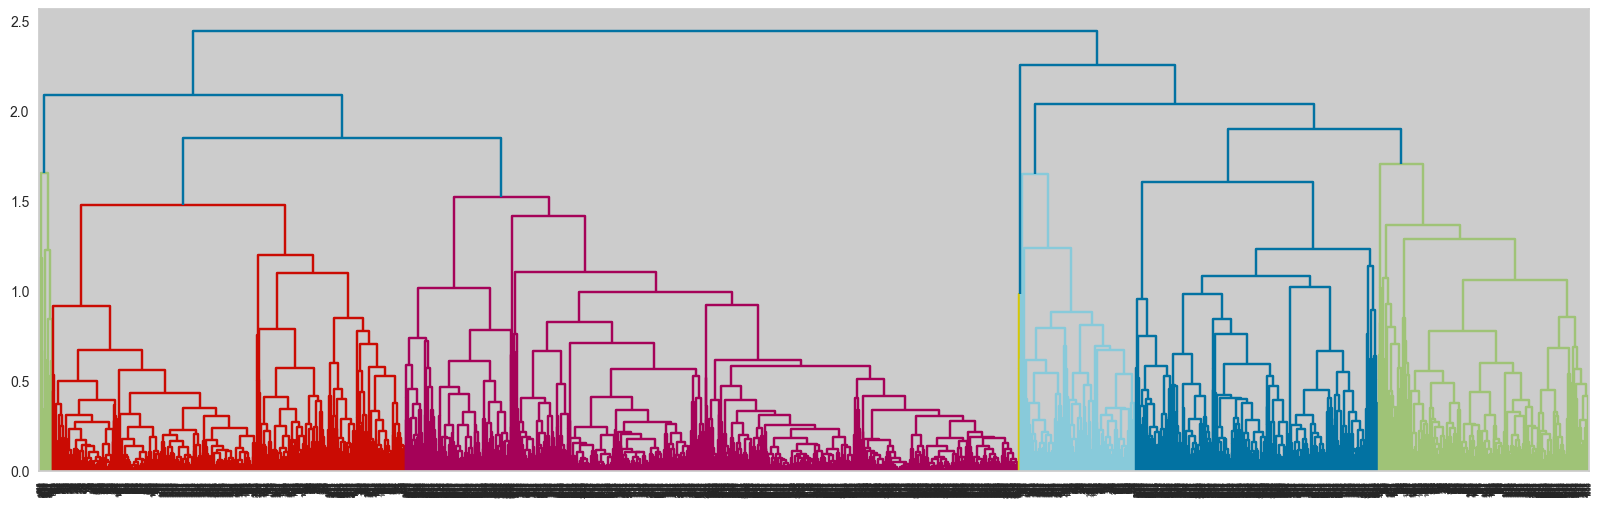

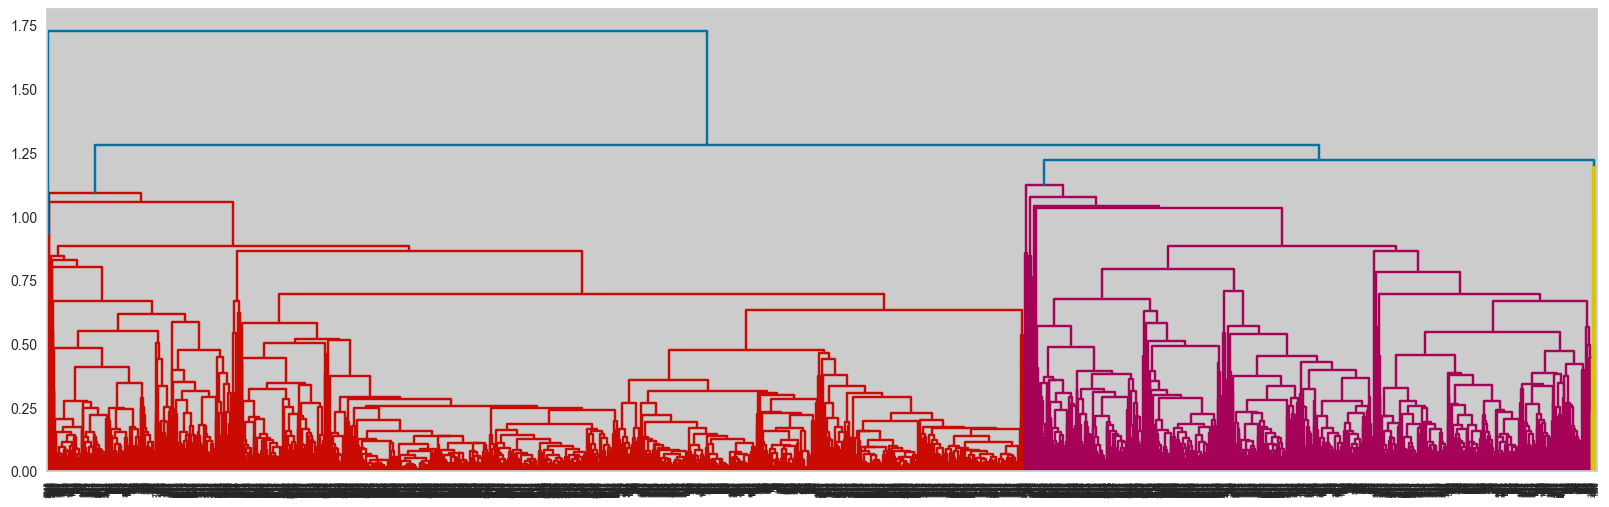

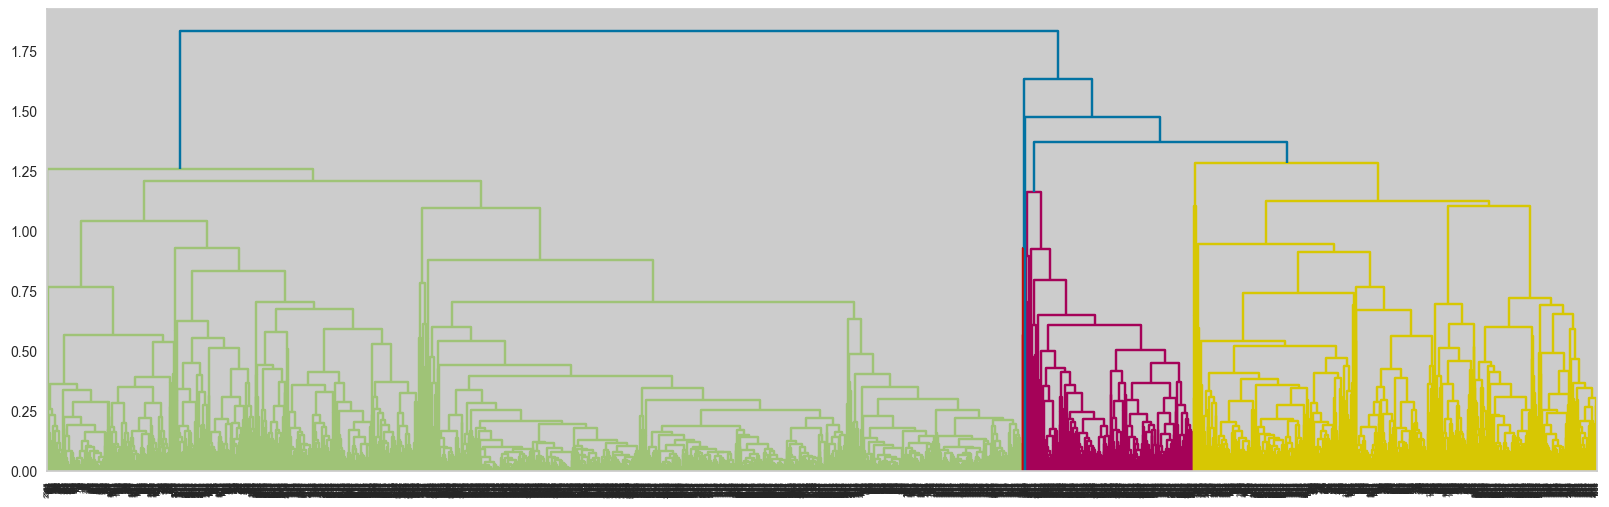

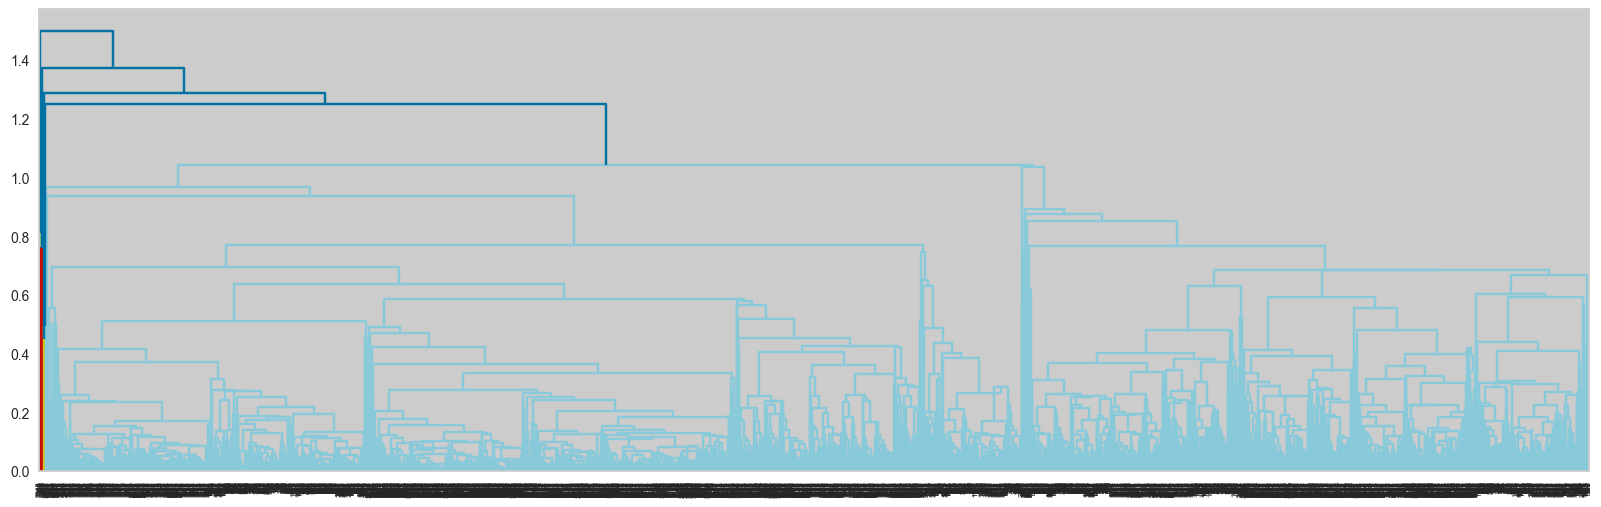

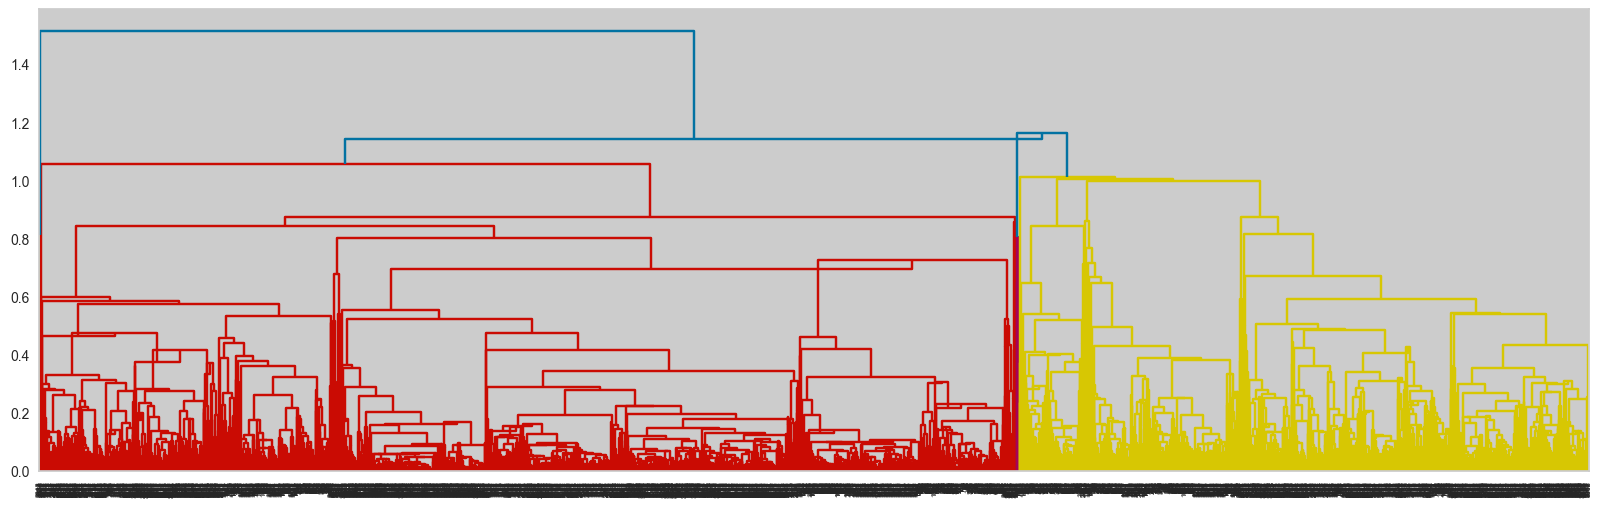

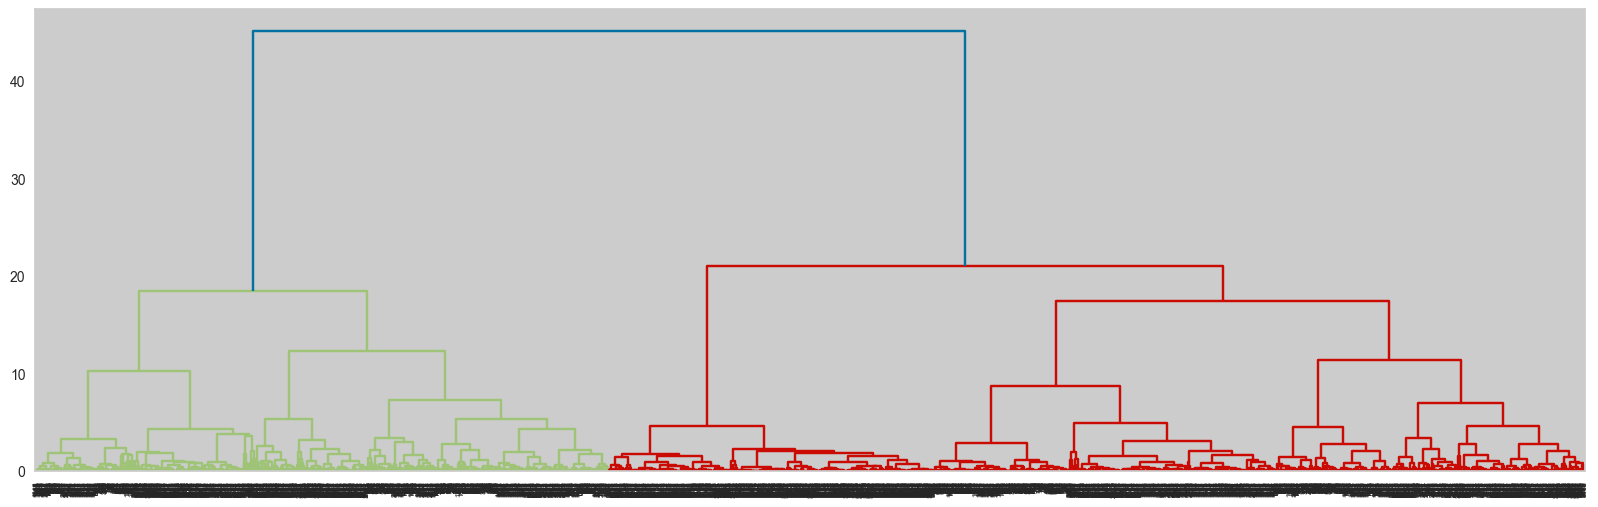

In [186]:
for methods in ['single','complete','average','weighted','centroid','median','ward']: 
    plt.figure(figsize =(20, 6)) 
    
    dict = {'fontsize':24,'fontweight' :16, 'color' : 'blue'}
    
    plt.title=('Visualising the data, Method- {}') 
    Dendrogram1 = sch.dendrogram(sch.linkage(data_norm, method = methods,optimal_ordering=False))

In [187]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(data_norm)
        silhouette_score1 = sil(data_norm, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.4701970394742716
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.46765873557390897
For n_clusters = 2 The average silhouette_score with linkage- average : 0.4356499222984323
For n_clusters = 2 The average silhouette_score with linkage- single : 0.4701970394742716

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.3434542103874939
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.4658447823503042
For n_clusters = 3 The average silhouette_score with linkage- average : 0.46834199629175055
For n_clusters = 3 The average silhouette_score with linkage- single : 0.46943588858264473

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.32621110074848614
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.4121977176126768
For n_clusters = 4 The average silhouette_score with linkage- average : 0.4383910691189487
F

In [188]:
#The seperation in Ward Method indicate that 2 is the optimal number for clusters.

# Dendrogram on Standard Scaler Applied on Data¶

In [189]:
n_clusters = [2,3,4,5,6,7,8,9,10]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(std_df)
        silhouette_score1 = sil(std_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.1952883252471116
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.7147570737481664
For n_clusters = 2 The average silhouette_score with linkage- average : 0.7986913036411657
For n_clusters = 2 The average silhouette_score with linkage- single : 0.8467289842517026

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.20526614352218822
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.7192161842959359
For n_clusters = 3 The average silhouette_score with linkage- average : 0.760749640995539
For n_clusters = 3 The average silhouette_score with linkage- single : 0.7172162983311359

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.21135914614865942
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.6276977845234434
For n_clusters = 4 The average silhouette_score with linkage- average : 0.7192609312303987
For 

In [190]:
#Conclusion: Max score is with cluster numbers 2 in standard scaler transformation and in Min Max scaler transformation.

# PCA

In [191]:
# applying PCA on std_df

# we are considering 95% variance in n_components to not loose any data.

from sklearn.decomposition import PCA
pca_std = PCA(random_state=10, n_components=0.95)
pca_std_df= pca_std.fit_transform(std_df)

In [192]:
# eigenvalues..

print(pca_std.singular_values_)

[117.45181285  87.52421792  78.64793243  63.94851715  62.63657788
  61.91156422  57.15380846  51.03898123  37.96085035]


In [193]:
# variance containing in each formed PCA

print(pca_std.explained_variance_ratio_*100)

[28.7466207  15.96334234 12.88967508  8.52174053  8.17567077  7.98750059
  6.80703055  5.42839378  3.00288855]


In [194]:
# Cummulative variance ratio..

# this will give an idea of, at how many no. of PCAs, the cummulative addition of
#........variance will give much information..

cum_variance = np.cumsum(pca_std.explained_variance_ratio_*100)
cum_variance

array([28.7466207 , 44.70996304, 57.59963812, 66.12137865, 74.29704942,
       82.28455001, 89.09158056, 94.51997434, 97.52286289])

# by applying PCA on standardized data with 95% variance it gives 9 PCA components.

# Silhouette Score method for PCA Standard Scaled Data

In [195]:
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster1 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels1 = hie_cluster1.fit_predict(pca_std_df)
        silhouette_score1 = sil(pca_std_df, hie_labels1)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score1)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.18255662664414418
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.798739567784828
For n_clusters = 2 The average silhouette_score with linkage- average : 0.798739567784828
For n_clusters = 2 The average silhouette_score with linkage- single : 0.8456193779284614

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.18597105571202124
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.7635930601533021
For n_clusters = 3 The average silhouette_score with linkage- average : 0.7635930601533021
For n_clusters = 3 The average silhouette_score with linkage- single : 0.7207874487389192

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.19335400761106325
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.6484324809831109
For n_clusters = 4 The average silhouette_score with linkage- average : 0.7152354220957933
For 

# Run Hierarchical Clustering.(Agglomerative Clustering) 

In [196]:
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_pred_hie = agg_clustering.fit_predict(pca_std_df)
print(y_pred_hie.shape)
y_pred_hie

(3999,)


array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [197]:

agg_clustering.n_clusters_

2

In [198]:
# Clustering Score

(sil(pca_std_df, agg_clustering.labels_)*100).round(3)

18.256

In [199]:
# Concating Labels with main dataset copy

df['Hierarchical_labels'] = agg_clustering.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1


In [200]:
df.groupby('Hierarchical_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Hierarchical_labels,,,,,,,,,,,,,
0,2307.166475,36273.649770,7.445853,1.087558,1.03341,1.000000,3109.720046,6.371544,102.221774,0.352535,3587.029954,0.009793,0.990207
1,1790.553248,102236.258506,248.956253,2.805126,1.00000,1.021653,27911.518338,15.614229,734.558551,2.156871,4526.307998,0.646929,0.353071


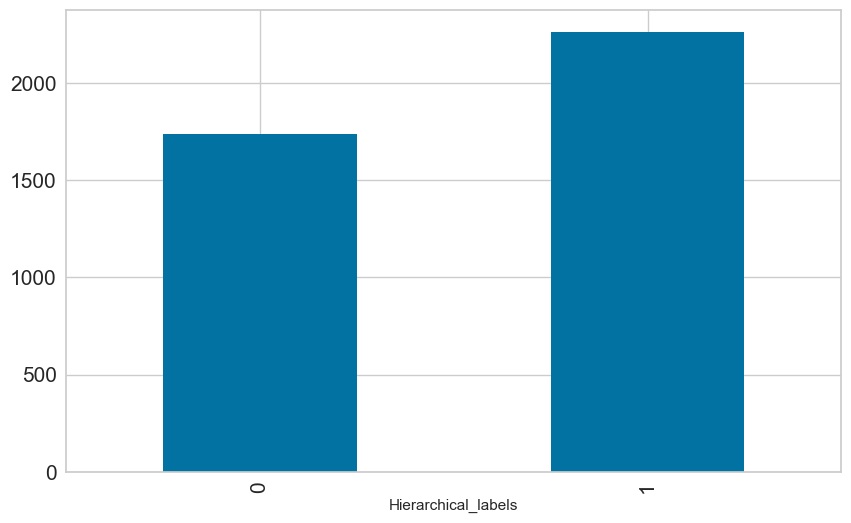

In [201]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Hierarchical_labels']).count()['ID'].plot(kind='bar')
plt.ylabel=('ID Counts')
plt.title=('Hierarchical Clustering PCA standard Scaled Data')
ax.set_xlabel=('Clusters')
ax.set_ylabel=('ID counts')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# Running PCA of MinMaxscalar data.

In [202]:
# applying PCA on minmax_df

from sklearn.decomposition import PCA

pca_minmax =  PCA(random_state=10, n_components=0.95)
pca_minmax_df = pca_minmax.fit_transform(data_norm)

In [203]:
# eigenvalues..

print(pca_minmax.singular_values_)

[33.23903239 23.19486627 19.58010291  6.55453842]


In [204]:
# variance containing in each formed PCA

print(pca_minmax.explained_variance_ratio_*100)

[51.05215542 24.85999765 17.71524966  1.98518765]


In [205]:
#Conclusion:
#By applying PCA on MinMaxscalr transformation data gives 4 PCA components.

# Silhouette Score method for PCA MinMax Scaled Data

In [206]:
n_clusters = [2,3,4,5,6,7,8]  # always start number from 2.

for n_clusters in n_clusters:
    for linkages in ["ward", "complete", "average", "single"]:
        hie_cluster2 = AgglomerativeClustering(n_clusters=n_clusters,linkage=linkages) # bydefault it takes linkage 'ward'
        hie_labels2 = hie_cluster2.fit_predict(pca_minmax_df)
        silhouette_score2 = sil(pca_minmax_df, hie_labels2)
        print("For n_clusters =", n_clusters,"The average silhouette_score with linkage-",linkages, ':',silhouette_score2)
    print()

For n_clusters = 2 The average silhouette_score with linkage- ward : 0.48989797089909976
For n_clusters = 2 The average silhouette_score with linkage- complete : 0.4409716437124455
For n_clusters = 2 The average silhouette_score with linkage- average : 0.48989797089909976
For n_clusters = 2 The average silhouette_score with linkage- single : 0.48989797089909976

For n_clusters = 3 The average silhouette_score with linkage- ward : 0.3813260038022784
For n_clusters = 3 The average silhouette_score with linkage- complete : 0.48755786490179676
For n_clusters = 3 The average silhouette_score with linkage- average : 0.4639024871740154
For n_clusters = 3 The average silhouette_score with linkage- single : 0.4685092099562149

For n_clusters = 4 The average silhouette_score with linkage- ward : 0.4157785217870237
For n_clusters = 4 The average silhouette_score with linkage- complete : 0.43430088381361587
For n_clusters = 4 The average silhouette_score with linkage- average : 0.4424737263379366


In [207]:
#Max score is with cluster numbers 2 for ward and mostly others.

# Run Hierarchical Clustering.(Agglomerative Clustering)

In [208]:
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
y_pred_hie = agg_clustering.fit_predict(pca_minmax_df)
print(y_pred_hie.shape)
y_pred_hie

(3999,)


array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [209]:
# Cluster numbers

agg_clustering.n_clusters_

2

In [210]:
# Clustering Score

(sil(pca_minmax_df, agg_clustering.labels_)*100).round(3)

48.99

In [211]:
# Concating Labels with main dataset copy

df['Hierarchical_labels'] = agg_clustering.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1


In [212]:
df.groupby('Hierarchical_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
Hierarchical_labels,,,,,,,,,,,,,
0,2173.169182,59807.839555,87.602462,1.705322,1.01390,1.008737,10227.689039,9.142971,226.292295,0.652502,3820.652105,0.0,1.0
1,1745.592843,97053.051317,240.196489,2.661715,1.01553,1.018231,28905.414585,15.782579,857.501013,2.599595,4625.062120,1.0,0.0


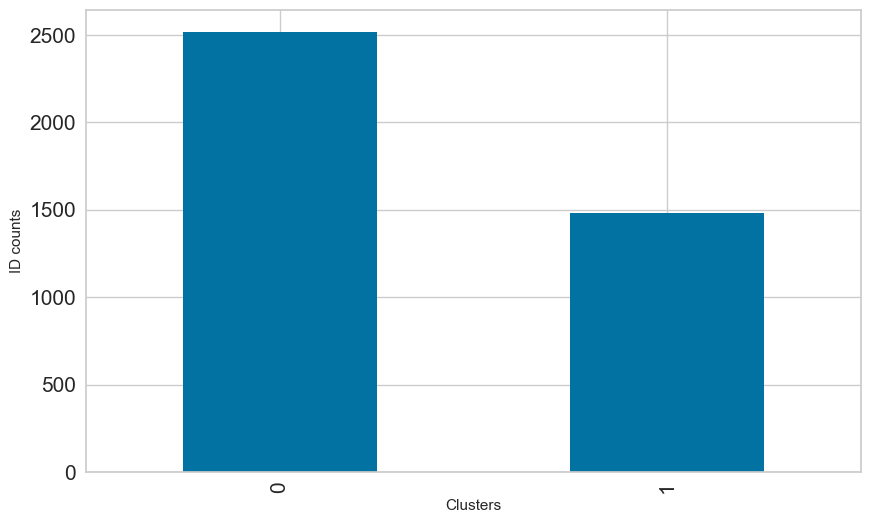

In [213]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['Hierarchical_labels']).count()['ID'].plot(kind='bar')
plt.ylabel=('ID Counts')
plt.title=('Hierarchical Clustering PCA MinMax Scaled Data')
ax.set_xlabel('Clusters')
ax.set_ylabel('ID counts')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

# DBSCAN

In [214]:
from itertools import product

eps_values = np.arange(0.25,1.25,0.25) # eps values to be investigated
min_samples = np.arange(3,23) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

In [215]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(data_norm)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(data_norm, DBS_clustering.labels_))

A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.


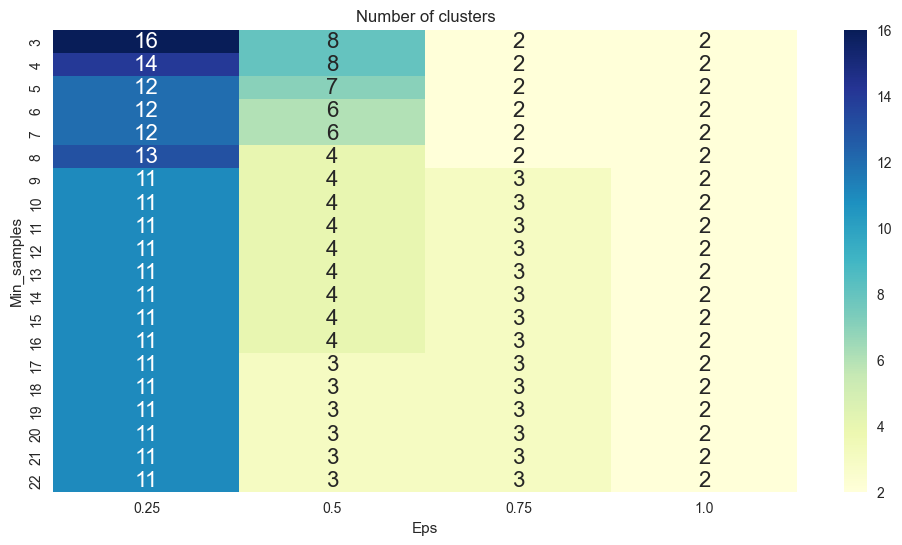

In [216]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
print('A heatplot below shows how many clusters were genreated by the algorithm for the respective parameters combinations.')
plt.show()

In [217]:
#As the heatplot above shows, the number of clusters vary from 18 to 2.

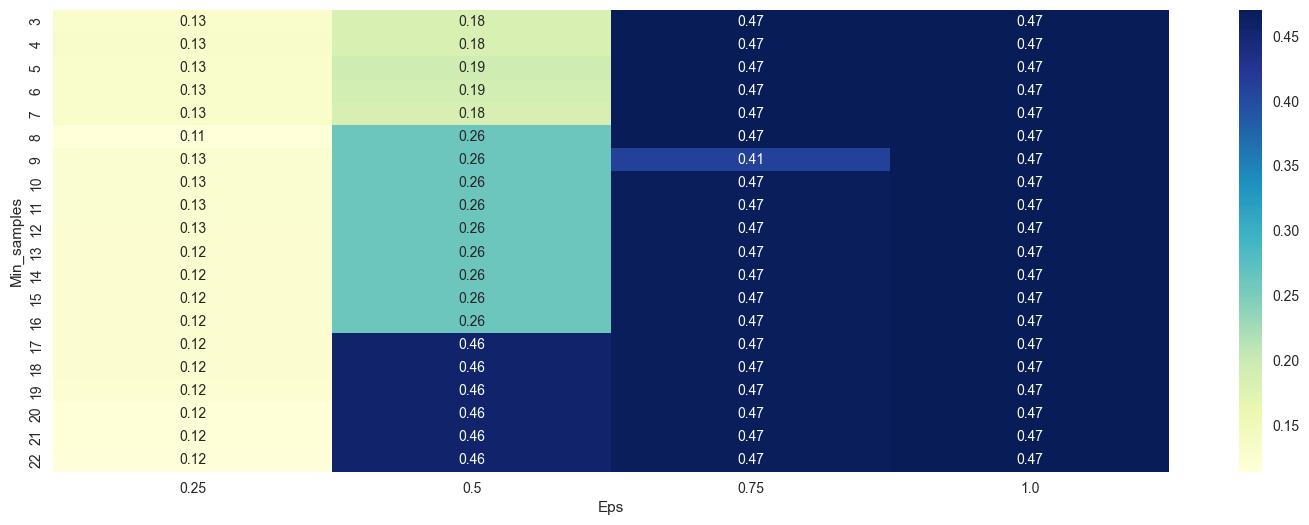

In [218]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [219]:
#Global maximum is 0.54 for eps=1.0 and min_samples=from 22 to 3

In [220]:
epsilon = [0.25,0.5,0.75,1]
min_samples = [11,12,13,14,15,16,17,18,19,20,21,22]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(data_norm)
        #cluster_labels=dbscan.fit_predict(data) 
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = sil(data_norm, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0], 
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 1 
min_sample= 11 
number of clusters= 2 
average silhouette score= 0.4702


In [221]:
epsilon = [0.25,0.5,0.75,1]
min_samples = [3,4,5,6,7,8,9,10,11]


sil_avg = []
max_value = [0,0,0,0]

for i in range(len(epsilon)):
    for j in range(len(min_samples)):

        db = DBSCAN(min_samples = min_samples[j], eps =epsilon[i]).fit(data_norm)
        #cluster_labels=dbscan.fit_predict(data) 
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)


        silhouette_avg = sil(data_norm, labels)
        if silhouette_avg > max_value[3]:
            max_value=(epsilon[i], min_samples[j], n_clusters_, silhouette_avg)
        sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0], 
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 0.75 
min_sample= 3 
number of clusters= 2 
average silhouette score= 0.4702


In [222]:
dbscan = DBSCAN(eps=1, min_samples=22) # min_samples = number of clumns * 3
dbscan.fit(data_norm)

DBSCAN(eps=1, min_samples=22)

In [223]:
dbscan.labels_

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [224]:
# -1 are the noise points in our dataset and the rest are the clusters

In [225]:
# Concating Labels with main dataset copy

df['DBSCAN_labels'] = dbscan.labels_
df.head()

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels,DBSCAN_labels
0,1,28143,0,1,1,1,174,1,0,0,7000,0,1,0,0
1,2,19244,0,1,1,1,215,2,0,0,6968,0,1,0,0
2,3,41354,0,1,1,1,4123,4,0,0,7034,0,1,0,0
3,4,14776,0,1,1,1,500,1,0,0,6952,0,1,0,0
4,5,97752,0,4,1,1,43300,26,2077,4,6935,1,0,1,1


In [226]:
df.groupby('DBSCAN_labels').agg(['mean'])

,ID,Balance,Qual_miles,cc1_miles,cc2_miles,cc3_miles,Bonus_miles,Bonus_trans,Flight_miles_12mo,Flight_trans_12,Days_since_enroll,Award,Kmeans_label,Hierarchical_labels
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
DBSCAN_labels,,,,,,,,,,,,,,
0,2173.169182,59807.839555,87.602462,1.705322,1.01390,1.008737,10227.689039,9.142971,226.292295,0.652502,3820.652105,0.0,1.0,0.0
1,1745.592843,97053.051317,240.196489,2.661715,1.01553,1.018231,28905.414585,15.782579,857.501013,2.599595,4625.062120,1.0,0.0,1.0


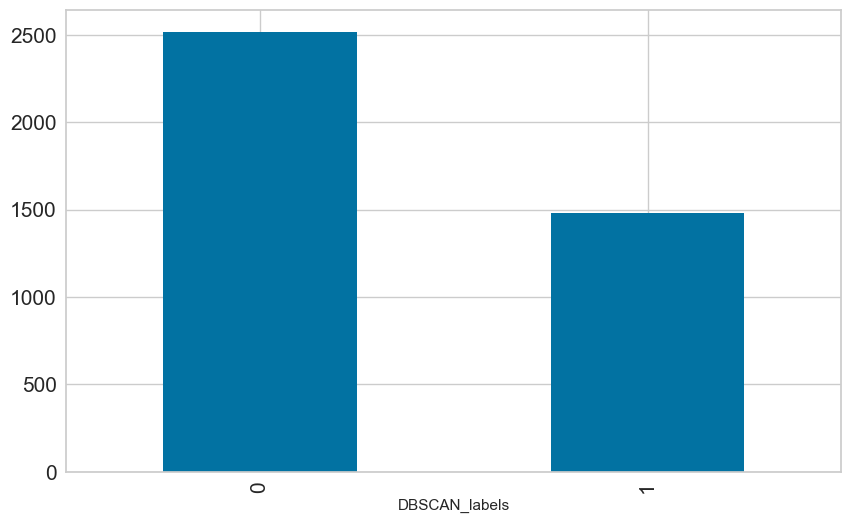

In [227]:
# Plotting barplot using groupby method to get visualize how many row no. in each cluster

fig, ax = plt.subplots(figsize=(10, 6))
df.groupby(['DBSCAN_labels']).count()['ID'].plot(kind='bar')
plt.ylabel=('ID Counts')
plt.title=('DBSCAN Clustering MinMax Scaled Data')
ax.set_xlabel=('Clusters')
ax.set_ylabel=('ID counts')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

In [228]:
#In cluster number 0 & 1 there are more customers. Need to focus on cluster 0 & 1.


In [229]:
# Sorting elements based on cluster label assigned and taking average for insights.

cluster1 = pd.DataFrame(df.loc[df.DBSCAN_labels==0].mean(),columns= ['Cluster1_avg'])
cluster2 = pd.DataFrame(df.loc[df.DBSCAN_labels==1].mean(),columns= ['Cluster2_avg'])

In [230]:
avg_df = pd.concat([cluster1,cluster2],axis=1)
avg_df

,Cluster1_avg,Cluster2_avg
ID,2173.169182,1745.592843
Balance,59807.839555,97053.051317
Qual_miles,87.602462,240.196489
cc1_miles,1.705322,2.661715
cc2_miles,1.013900,1.015530
cc3_miles,1.008737,1.018231
Bonus_miles,10227.689039,28905.414585
Bonus_trans,9.142971,15.782579
Flight_miles_12mo,226.292295,857.501013
Flight_trans_12,0.652502,2.599595


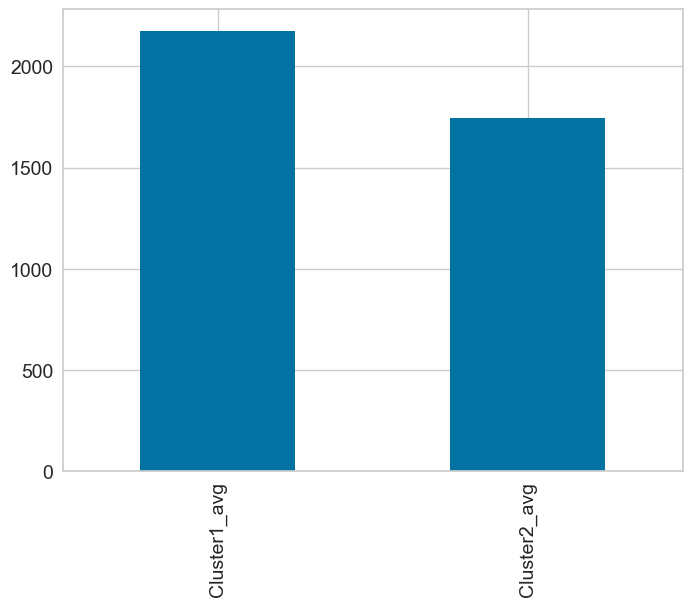

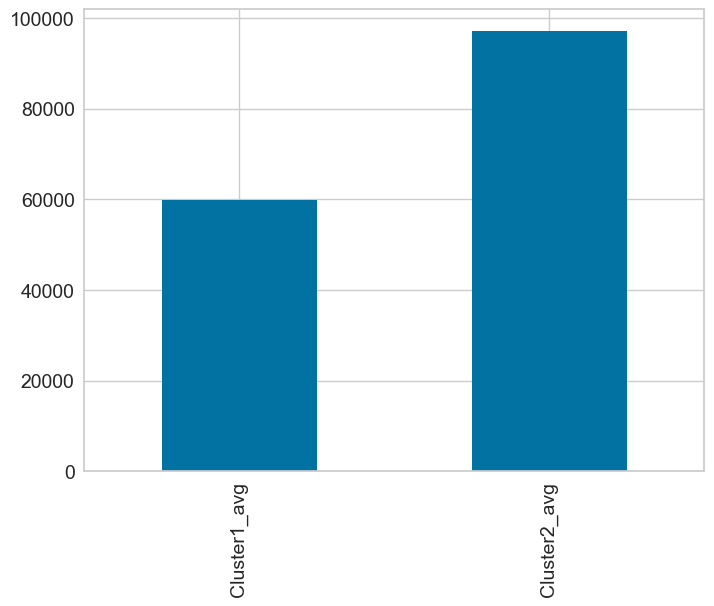

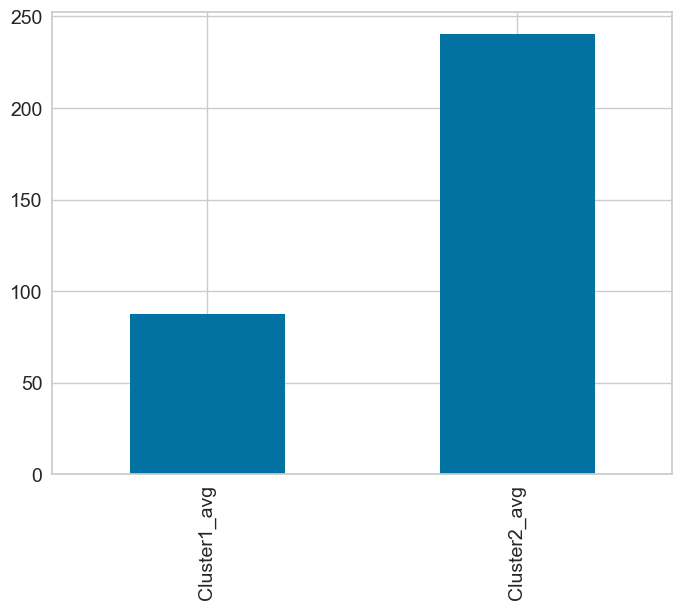

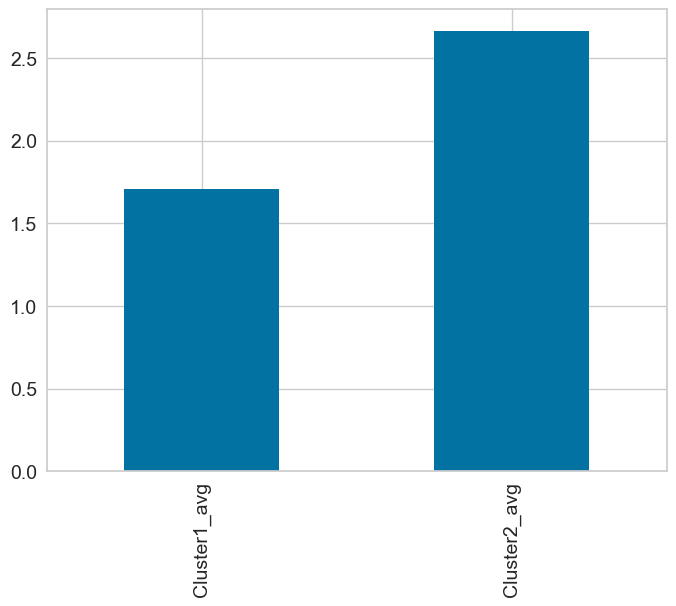

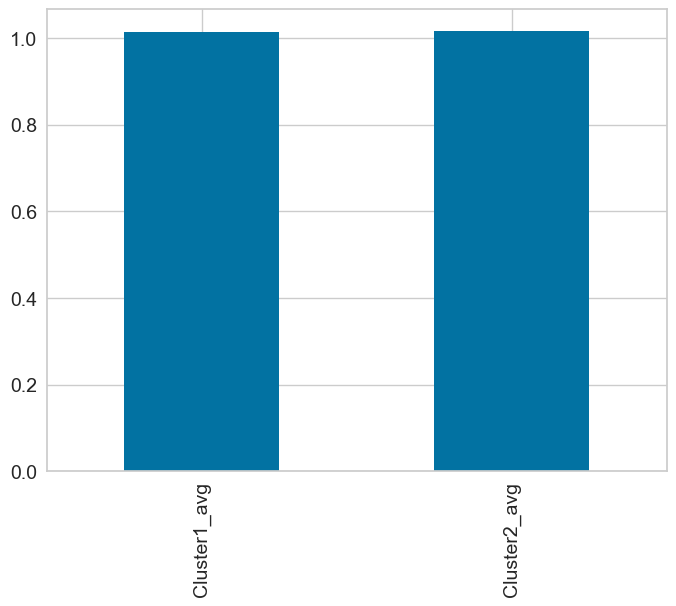

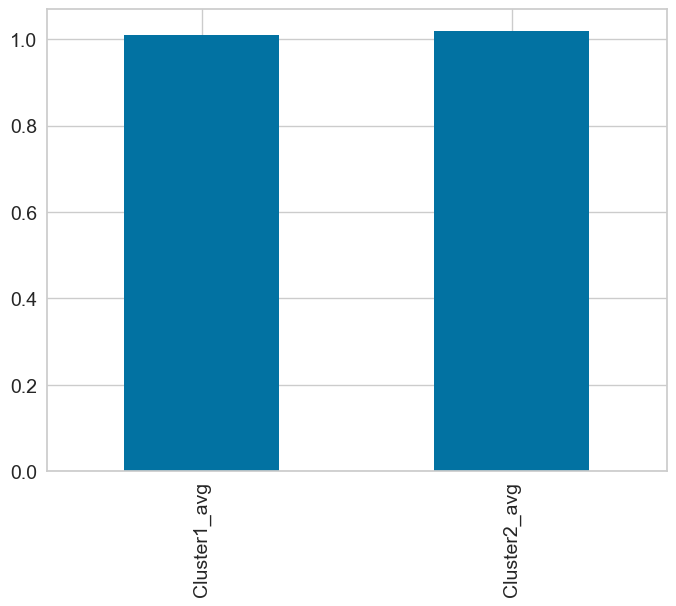

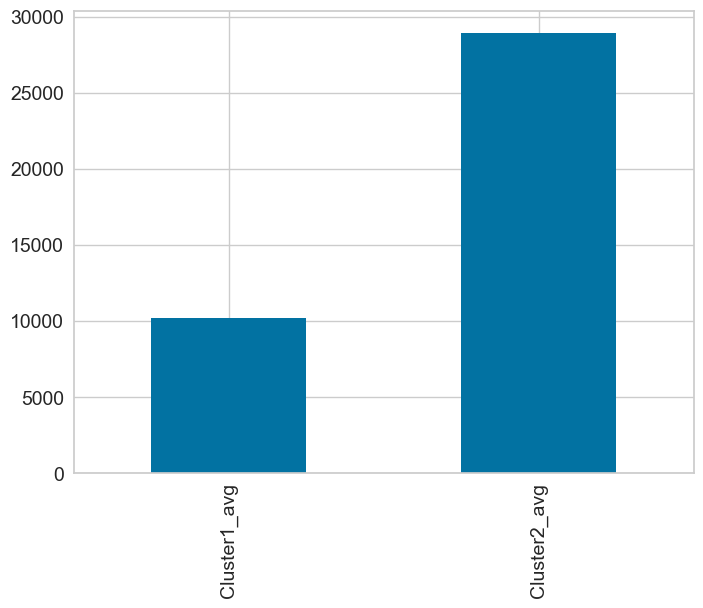

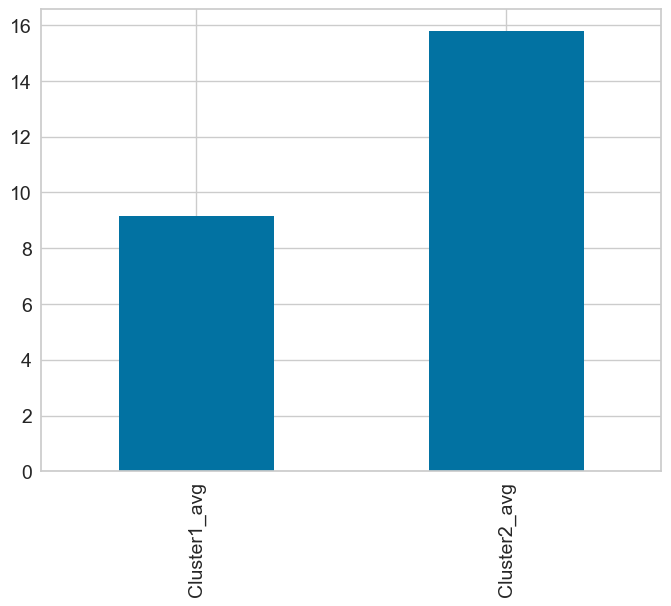

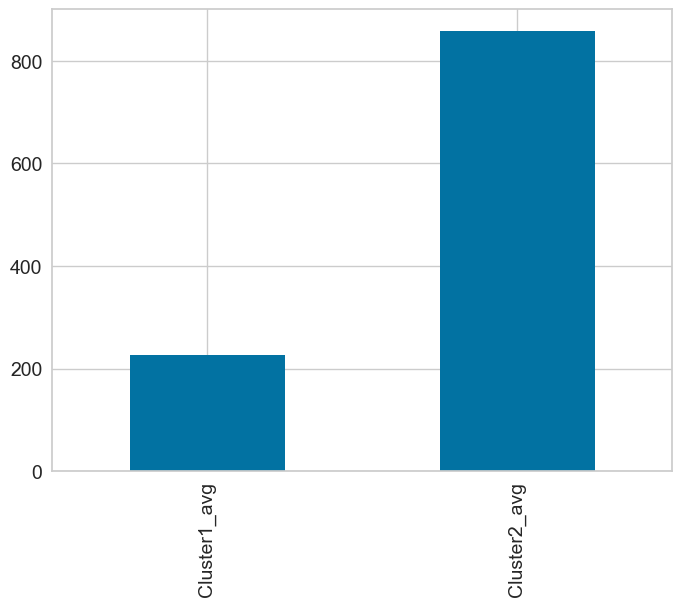

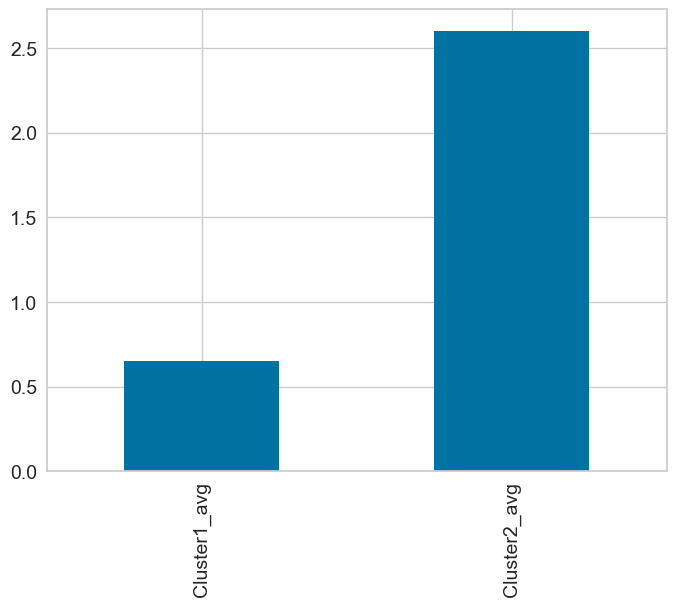

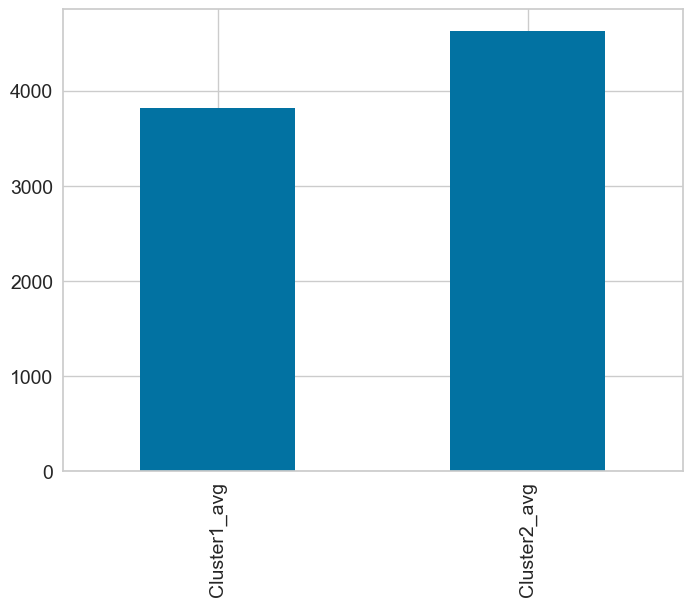

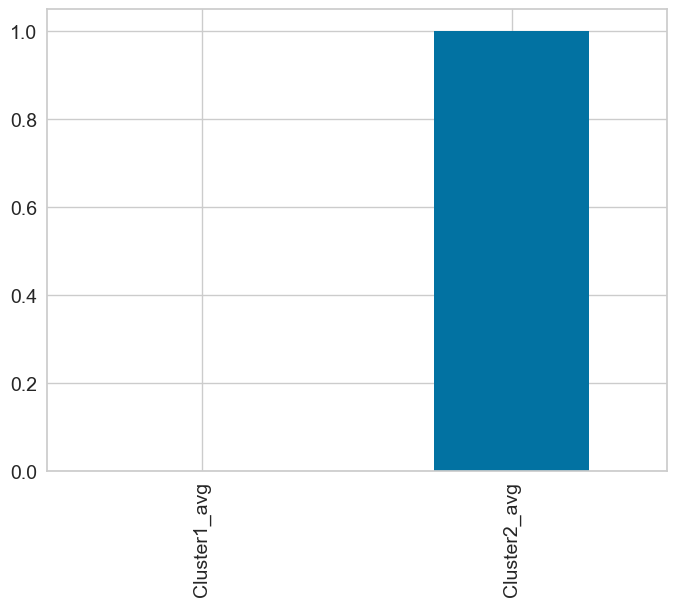

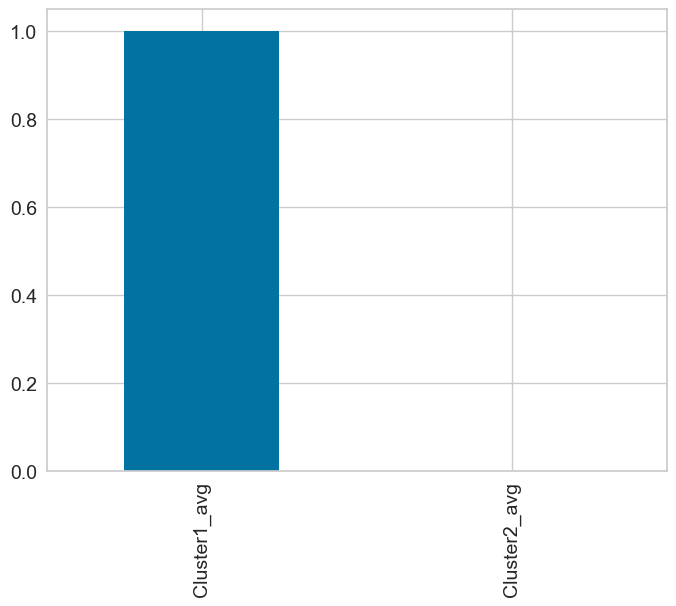

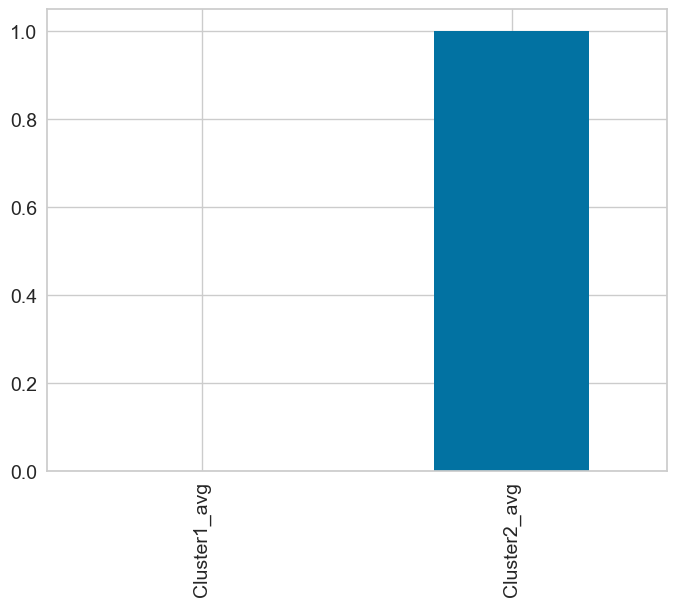

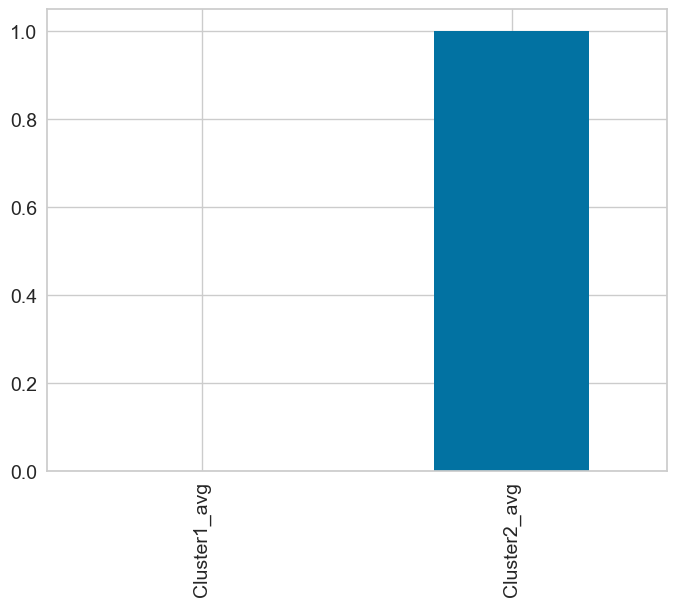

In [231]:
# Extract and plot one Column data .xs method
for i , row in avg_df.iterrows():
    fig = plt.subplots(figsize=(8,6))
    j = avg_df.xs(i ,axis = 0)
    plt.title=(i)
    j.plot(kind='bar',fontsize=14)
    plt.show()
    print()